# Carbon Intensity Analysis - Group_2
## Objective:
To analyze carbon intensity (CI) data across sectors, regions, and value chain stages using the PCF-Database, identifying significant differences to help Global Trade Alliance reduce the environmental impact of their distributed products.

## Task Description:
As a sustainability data analyst at EcoFuture Analytics, your task is to analyze CI data from the PCF-Database to identify sectoral, regional, and value chain differences. Using statistical tests and visualizations, you will provide insights to Global Trade Alliance for developing policies to minimize their products' carbon footprint.


In [1]:
#import necessary packages for the objective
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Get rid of FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Read the source data to a pandas datafarme, inspect its key features and clean the data for further analysis

Dataset Preview:
         *PCF-ID  Year of reporting *Stage-level CO2e available  \
0  10056-1-2014               2014                         Yes   
1  10056-1-2015               2015                         Yes   
2  10222-1-2013               2013                         Yes   
3  10261-1-2017               2017                         Yes   
4  10261-2-2017               2017                         Yes   

                  Product name (and functional unit)  \
0                           Frosted Flakes(R) Cereal   
1  Frosted Flakes, 23 oz, produced in Lancaster, ...   
2                                       Office Chair   
3                             Multifunction Printers   
4                             Multifunction Printers   

                                      Product detail               Company  \
0  Frosted Flakes(R), 23 oz., Produced in Lancast...       Kellogg Company   
1                                             Cereal       Kellogg Company   
2             

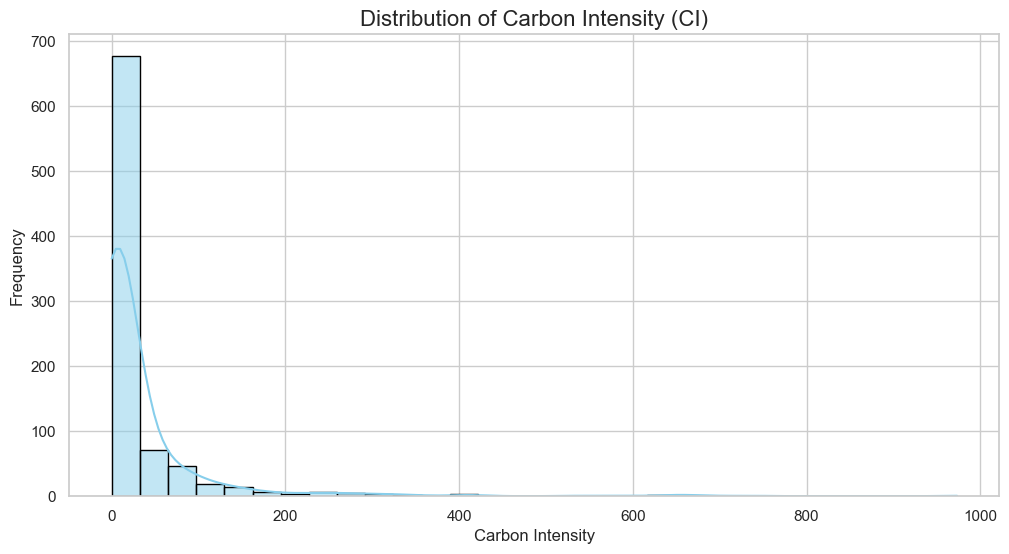


Sector Summary:
                       *Company's sector        mean   min     max  count
0              Automobiles & components   21.599867  0.99   84.36     75
1                             Chemicals    5.173017  0.12   94.00    116
2         Comm. equipm. & capital goods  106.041607  0.28  973.22     56
3                Computer, IT & telecom   75.294625  0.12  736.50    253
4   Construction & commercial materials    1.178955  0.21    6.51     67
5                       Food & Beverage    5.087266  0.11   74.64    139
6  Home durables, textiles, & equipment   13.283033  0.40  235.91    122
7          Packaging for consumer goods    1.276053  0.23    2.72     38


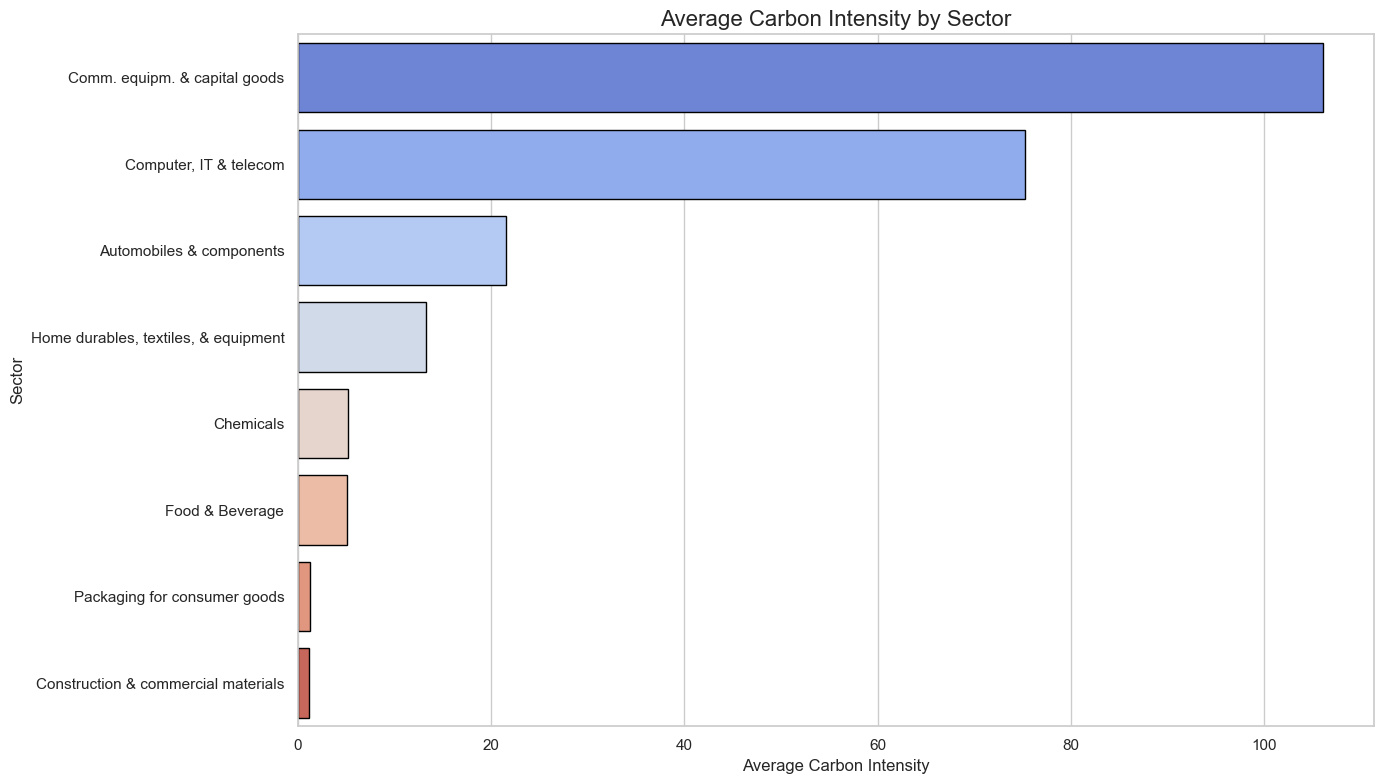


Country Summary:
    Country (where company is incorporated)  *Carbon intensity
0                                Australia          10.500000
1                                  Belgium           1.175000
2                                   Brazil         106.168235
3                                   Canada         370.148333
4                                    Chile           0.516667
5                                    China          44.586667
6                                 Colombia           0.175000
7                                  Finland           9.669714
8                                   France          60.863500
9                                  Germany          20.763582
10                                  Greece           0.700000
11                                   India           1.536250
12                               Indonesia           0.720000
13                                 Ireland           0.855000
14                                   Italy         

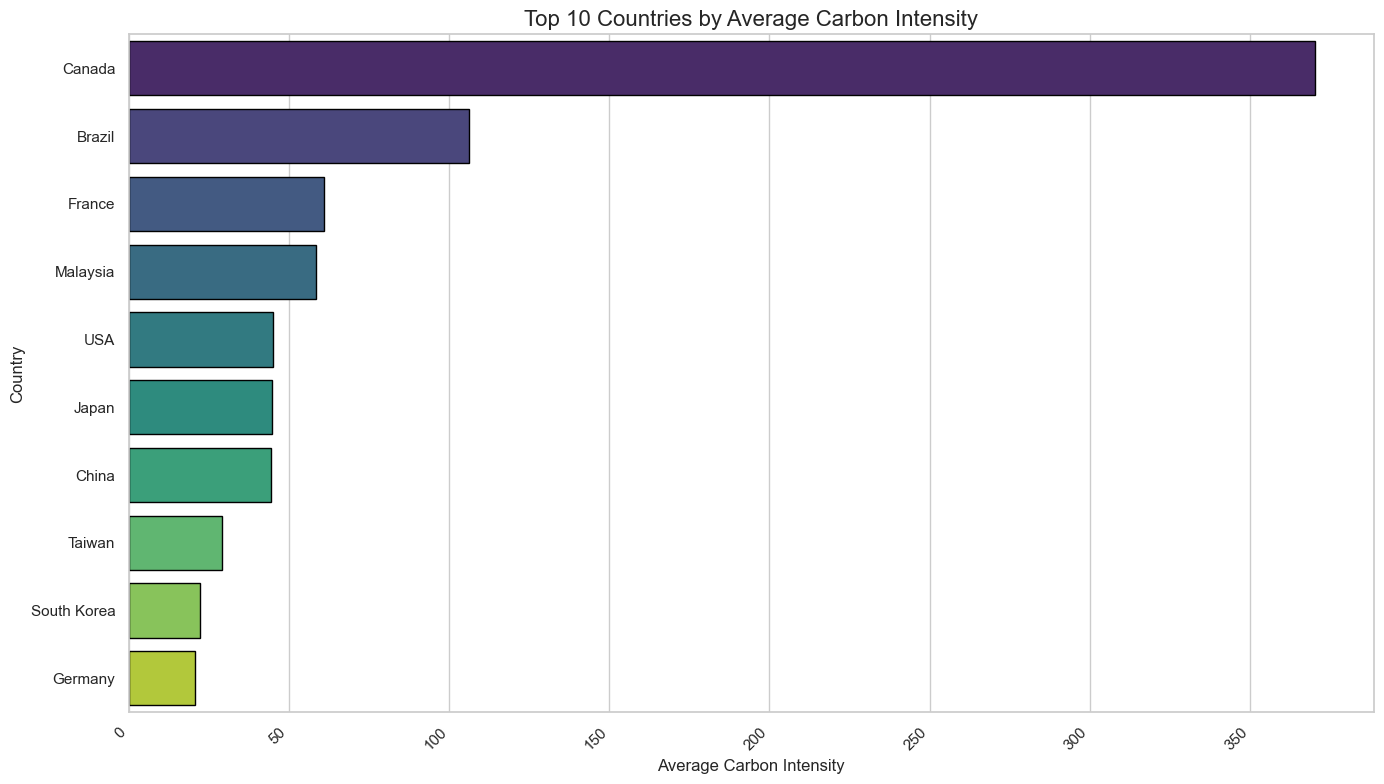

In [2]:
# Setting a Seaborn style
sns.set_theme(style="whitegrid", palette="pastel")  # Choose a clean and colorful theme

# Load the dataset
file_path = r'PublicTablesForCarbonCatalogueDataDescriptor_v30Oct2021.xlsx'
sheet_name = 'Product Level Data'  # Replace with the actual sheet name
sheet_name2='Stage Level Data' # replace with actual sheet name
source_ci_df = pd.read_excel(file_path, sheet_name=sheet_name)
source_ci_stage_level_df=pd.read_excel(file_path, sheet_name=sheet_name2)

# Preview the first few rows of the dataset
print("Dataset Preview:\n", source_ci_df.head())

# Check for missing values
missing_values = source_ci_df.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Check data types
print("\nData Types:\n", source_ci_df.dtypes)

# Remove duplicates (if any)
source_ci_df = source_ci_df.drop_duplicates()

# Basic statistics
print("\nBasic Statistics:\n", source_ci_df.describe())

# Verify column names
print("\nColumn Names:\n", source_ci_df.columns)

# Explore unique values in key columns
if '*Company\'s sector' in source_ci_df.columns and '*Carbon intensity' in source_ci_df.columns:
    print("\nUnique Sectors:\n", source_ci_df['*Company\'s sector'].unique())
    print("\nUnique Countries:\n", source_ci_df['Country (where company is incorporated)'].unique())

    # Check the distribution of carbon intensity (CI)
    plt.figure(figsize=(12, 6))
    sns.histplot(source_ci_df['*Carbon intensity'].dropna(), kde=True, bins=30, color="skyblue", edgecolor="black")
    plt.title('Distribution of Carbon Intensity (CI)', fontsize=16)
    plt.xlabel('Carbon Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

    # Group by sector and calculate average, min, and max CI
    sector_summary = source_ci_df.groupby('*Company\'s sector')['*Carbon intensity'].agg(['mean', 'min', 'max', 'count']).reset_index()
    print("\nSector Summary:\n", sector_summary)

    # Plot the average CI by sector
    plt.figure(figsize=(14, 8))
    sns.barplot(x='mean', y='*Company\'s sector', data=sector_summary.sort_values(by='mean', ascending=False), 
                palette='coolwarm', edgecolor="black")
    plt.title('Average Carbon Intensity by Sector', fontsize=16)
    plt.xlabel('Average Carbon Intensity', fontsize=12)
    plt.ylabel('Sector', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Group by country and calculate average CI
    country_summary = source_ci_df.groupby('Country (where company is incorporated)')['*Carbon intensity'].mean().reset_index()
    print("\nCountry Summary:\n", country_summary)

    # Plot the average CI by country (top 10 countries)
    top_countries = country_summary.sort_values(by='*Carbon intensity', ascending=False).head(10)
    plt.figure(figsize=(14, 8))
    sns.barplot(x='*Carbon intensity', y='Country (where company is incorporated)', data=top_countries,
                palette='viridis', edgecolor="black")
    plt.title('Top 10 Countries by Average Carbon Intensity', fontsize=16)
    plt.xlabel('Average Carbon Intensity', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found in the dataset. Verify column names!")


# Part 1: Comparing the carbon intensity across company's sectors
#### Objectives:
* Perform statistical analysis to find the significant differences in average carbon intensity (CI) among sectors.
* Find any sectors with overlapping CI ranges that make it difficult to distinguish their environmental performance.
* The possiblee reasons of the difference found.


In [3]:
####### Inspecting data########
display(source_ci_df.head())
display(source_ci_df.info())

,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,Product weight (kg),*Source for product weight,"Product's carbon footprint (PCF, kg CO2e)",*Carbon intensity,Protocol used for PCF,Relative change in PCF vs previous,Company-reported reason for change,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any)
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,0.7485,Estimated from external data based on product ...,2.00,2.67,Not reported,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,0.7485,Estimated from external data based on product ...,2.00,2.67,Not reported,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,20.6800,Estimated from external data based on product ...,72.54,3.51,Not reported,(not reported by company),N/a,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c..."
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",110.0000,Estimated from external data based on product ...,1488.00,13.53,ISO,(not reported by company),N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",110.0000,Estimated from external data based on product ...,1818.00,16.53,ISO,(not reported by company),N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   *PCF-ID                                    866 non-null    object 
 1   Year of reporting                          866 non-null    int64  
 2   *Stage-level CO2e available                866 non-null    object 
 3   Product name (and functional unit)         866 non-null    object 
 4   Product detail                             856 non-null    object 
 5   Company                                    866 non-null    object 
 6   Country (where company is incorporated)    866 non-null    object 
 7   Company's GICS Industry Group              866 non-null    object 
 8   Company's GICS Industry                    866 non-null    object 
 9   *Company's sector                          866 non-null    object 
 10  Product weight (kg)       

None

In [4]:
#### Cleaning the dataframe ####

### Filtering limited columns that are relevant for the analysis ###
ci_df = source_ci_df[['*PCF-ID','Year of reporting','Product name (and functional unit)','Product detail','Company',"*Company's sector",'*Carbon intensity']]
ci_df = ci_df.dropna(subset=['*Carbon intensity'])
ci_df.columns = ci_df.columns.str.replace('*', '', regex=False)
ci_df = ci_df.rename(columns={"Company's sector": 'Company\'s sector'})
display(ci_df.head())

,PCF-ID,Year of reporting,Product name (and functional unit),Product detail,Company,Company's sector,Carbon intensity
0,10056-1-2014,2014,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,Food & Beverage,2.67
1,10056-1-2015,2015,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,Food & Beverage,2.67
2,10222-1-2013,2013,Office Chair,Field not included in 2013 data,KNOLL INC,Comm. equipm. & capital goods,3.51
3,10261-1-2017,2017,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.","Computer, IT & telecom",13.53
4,10261-2-2017,2017,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.","Computer, IT & telecom",16.53


##### Inspecting key features of compay's sectors

Number of Sectors: 8
['Food & Beverage' 'Comm. equipm. & capital goods'
 'Computer, IT & telecom' 'Chemicals'
 'Construction & commercial materials'
 'Home durables, textiles, & equipment' 'Packaging for consumer goods'
 'Automobiles & components']
-----------------------------------------------


Company's sector
Computer, IT & telecom                  253
Food & Beverage                         139
Home durables, textiles, & equipment    122
Chemicals                               116
Automobiles & components                 75
Construction & commercial materials      67
Comm. equipm. & capital goods            56
Packaging for consumer goods             38
Name: count, dtype: int64

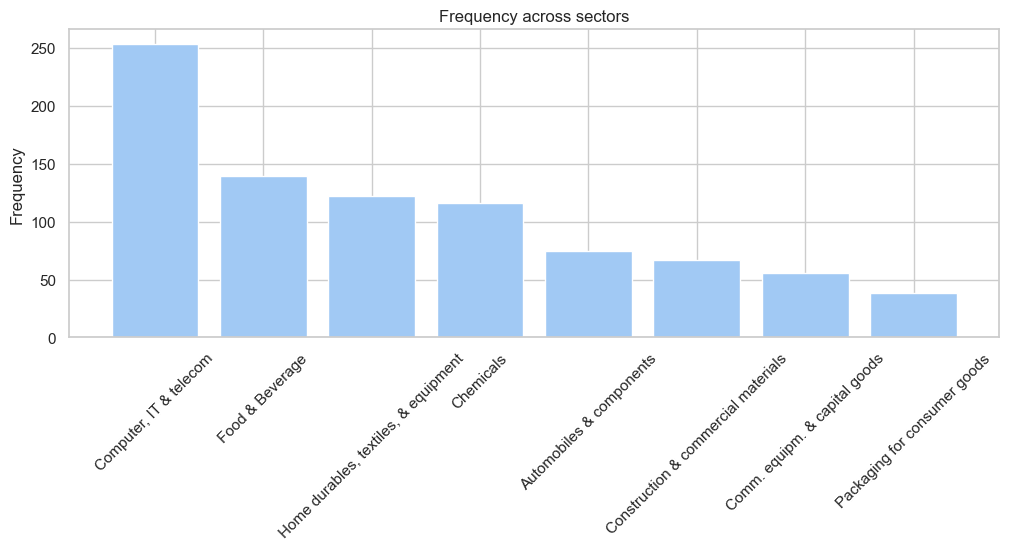

In [5]:
sectors = ci_df['Company\'s sector'].unique()
print(f"Number of Sectors: {len(sectors)}")
print(sectors)
print("-----------------------------------------------")
### ploting the frequency of entities across sectors ##
sector_counts = ci_df['Company\'s sector'].value_counts()
display(sector_counts)
plt.figure(figsize=(12, 4))
plt.bar(sector_counts.index, sector_counts.values)
plt.ylabel('Frequency')
plt.title('Frequency across sectors')
plt.xticks(rotation=45)
plt.show()

##### Plot the total carbon intensity across the sectors to understand which sector has the highest CI proportion.

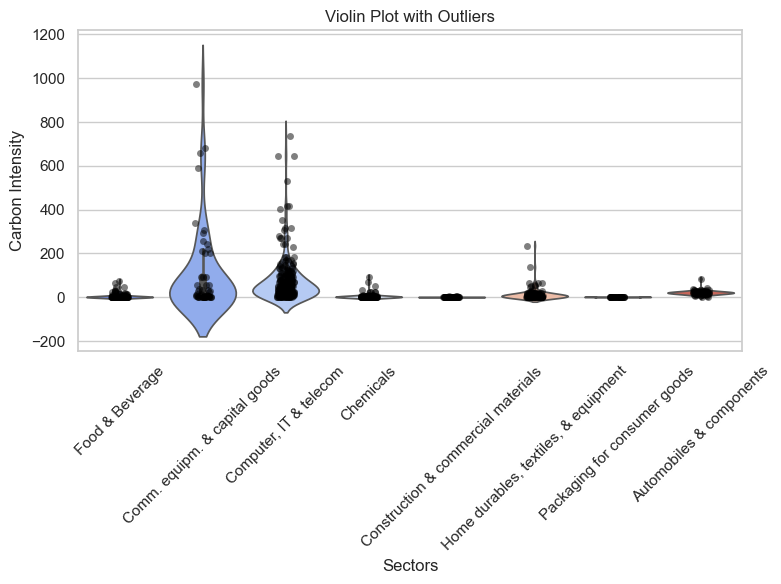

In [6]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Company\'s sector', y='Carbon intensity', data=ci_df, inner='box', palette='coolwarm')
sns.stripplot(x='Company\'s sector', y='Carbon intensity', data=ci_df, color='black', alpha=0.5, jitter=True)  # Overlay data points
plt.xlabel('Sectors')
plt.ylabel('Carbon Intensity')
plt.title('Violin Plot with Outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Plot individual ci vs sector to understand how the values are distributed across each individual sector

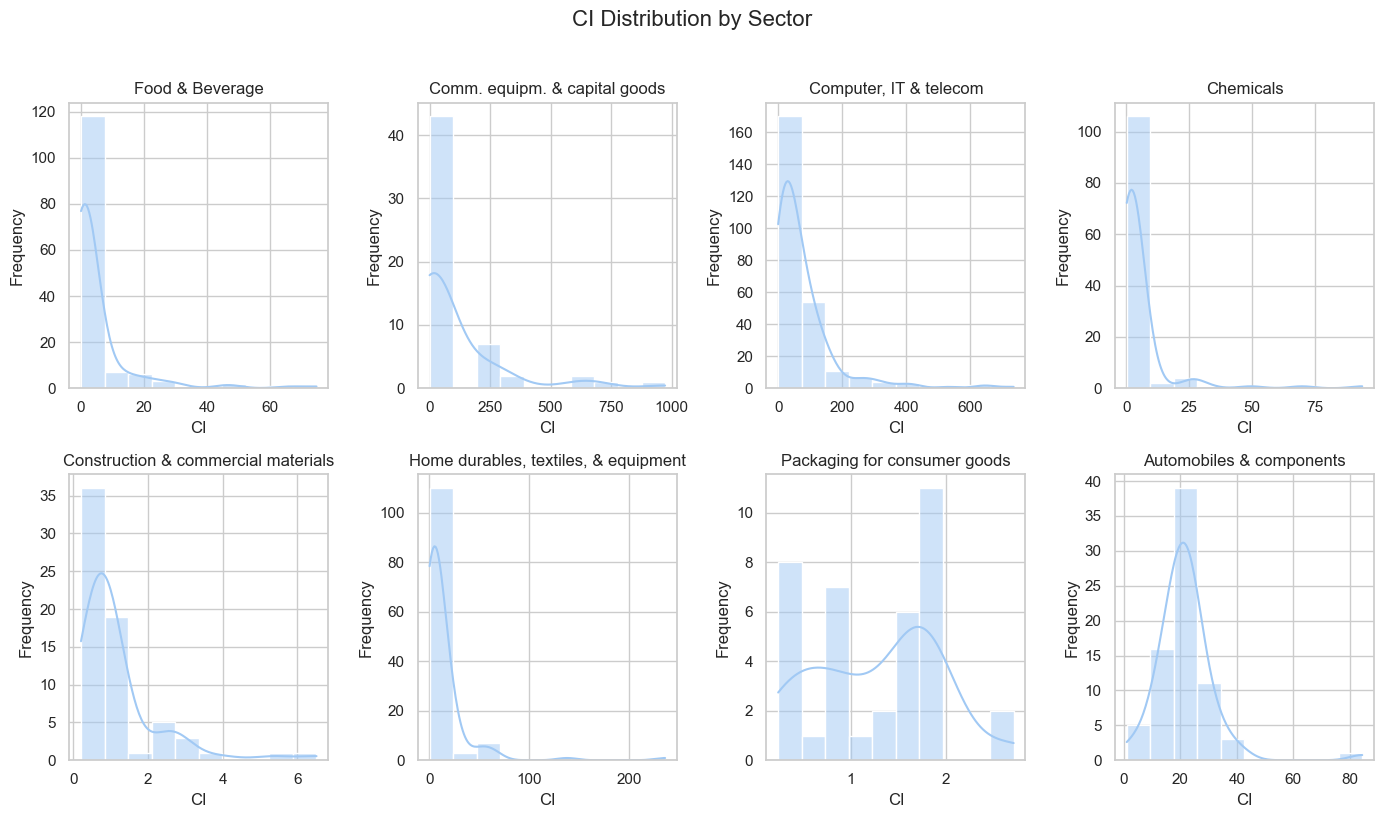

In [7]:
# Get unique sectors
sectors = ci_df['Company\'s sector'].unique()

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=False, sharey=False)

for ax, sector in zip(axes.flatten(), sectors):
    sector_data = ci_df[ci_df['Company\'s sector'] == sector]
    sns.histplot(sector_data['Carbon intensity'], bins=10, kde=True, ax=ax)
    ax.set_title(f"{sector}")
    ax.set_xlabel('CI')
    ax.set_ylabel('Frequency')

fig.suptitle('CI Distribution by Sector', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [8]:
print(ci_df.describe())

       Year of reporting  Carbon intensity
count         866.000000        866.000000
mean         2014.762125         34.252968
std             1.236720         84.599082
min          2013.000000          0.110000
25%          2014.000000          1.320000
50%          2015.000000          5.400000
75%          2016.000000         26.000000
max          2017.000000        973.220000


##### Observations and conclusions:
* Significant differences in sample sizes are observed between sectors such as "Computer, IT & Telecom" and "Packaging for Consumer Goods."

* A violin plot comparison reveals considerable variance in carbon intensity (CI) distributions. Sectors like Food & Beverage, Communication Equipment & Capital Goods, Computer, IT & Telecom, and Chemicals exhibit pronounced tails and broader density ranges, indicating a substantial spread in CI values within these sectors, with extreme values visibly represented at the edges of the violins.

* The histogram plots illustrate the CI distribution across individual sectors. Upon examination, the distribution appears normal for some sectors; however, sectors such as Food & Beverage and Chemicals show a concentration of values skewed toward the lower end.'

#### Perform statistical analysis to find the significant differences in average carbon intensity (CI) among sectors

##### Performing ANOVA to understand the differences

In [9]:
groups = [ci_df[ci_df['Company\'s sector'] == group]['Carbon intensity'] for group in ci_df['Company\'s sector'].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f'ANOVA result for CI: F-statistic = {f_stat}, p-value = {p_value}')
if p_value < 0.5:
    print('Significant differences found in CI accross Company sectors')

ANOVA result for CI: F-statistic = 26.818165245662108, p-value = 2.2201664774717847e-33
Significant differences found in CI accross Company sectors


##### Conclusion:
The ANOVA results for carbon intensity (CI), with an F-statistic of 26.82 and a p-value of 2.22e-33, indicate significant differences in CI across company sectors. This suggests that the sectors exhibit varying carbon intensity levels, likely influenced by industry-specific factors, operational practices, or resource usage.

Further Steps:
* Post-Hoc Testing: Conduct post-hoc pairwise comparisons (e.g., Tukey HSD test) to identify which specific sectors differ significantly in terms of CI.
* Sector Analysis: Investigate the underlying factors contributing to these differences by examining sector-specific practices, technologies, and sustainability initiatives.
* Visual Representation: Use additional visualizations, such as box plots or violin plots, to further illustrate the spread and distribution of CI values within each sector.

#### Performing post hoc testing with Tukey HSD group pair comparison

In [10]:
ci_tukey = pairwise_tukeyhsd(ci_df['Carbon intensity'], ci_df['Company\'s sector'])
print(ci_tukey.summary())

                                Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
               group1                               group2                 meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------------------------------------------------
            Automobiles & components                            Chemicals  -16.4268  0.838   -51.066  18.2123  False
            Automobiles & components        Comm. equipm. & capital goods   84.4417    0.0    43.154 125.7295   True
            Automobiles & components               Computer, IT & telecom   53.6948    0.0   22.9581  84.4314   True
            Automobiles & components  Construction & commercial materials  -20.4209  0.763  -59.7204  18.8785  False
            Automobiles & components                      Food & Beverage  -16.5126 0.8087  -50.0075  16.9823  False
            Automobiles & components Home durables, textiles, & 

In [11]:
# convert the summary to a pondas dataframe 
ci_tukey_df = pd.DataFrame(data=ci_tukey._results_table.data[1:], columns=ci_tukey._results_table.data[0])
ci_df_sorted = ci_tukey_df.sort_values(by='meandiff', key=abs, ascending=False)
ci_df_sorted.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
14,Comm. equipm. & capital goods,Construction & commercial materials,-104.8627,0.0,-147.1910,-62.5343,True
17,Comm. equipm. & capital goods,Packaging for consumer goods,-104.7656,0.0,-153.9003,-55.6308,True
15,Comm. equipm. & capital goods,Food & Beverage,-100.9543,0.0,-137.9564,-63.9522,True
7,Chemicals,Comm. equipm. & capital goods,100.8686,0.0,62.8276,138.9096,True
16,Comm. equipm. & capital goods,"Home durables, textiles, & equipment",-92.7586,0.0,-130.4938,-55.0234,True


In [12]:
# Investigating the groups
duplicates = ci_df_sorted.duplicated(subset=['group1', 'group2']).sum()
print(f"Number of duplicates: {duplicates}")
print("Group1 and Group2")
display(ci_df_sorted['group1'].unique())
display(ci_df_sorted['group2'].unique())

Number of duplicates: 0
Group1 and Group2


array(['Comm. equipm. & capital goods', 'Chemicals',
       'Automobiles & components', 'Computer, IT & telecom',
       'Construction & commercial materials',
       'Home durables, textiles, & equipment', 'Food & Beverage'],
      dtype=object)

array(['Construction & commercial materials',
       'Packaging for consumer goods', 'Food & Beverage',
       'Comm. equipm. & capital goods',
       'Home durables, textiles, & equipment', 'Computer, IT & telecom',
       'Chemicals'], dtype=object)

##### Plotting the groups vs meandiff over a heat map to examine the differences.

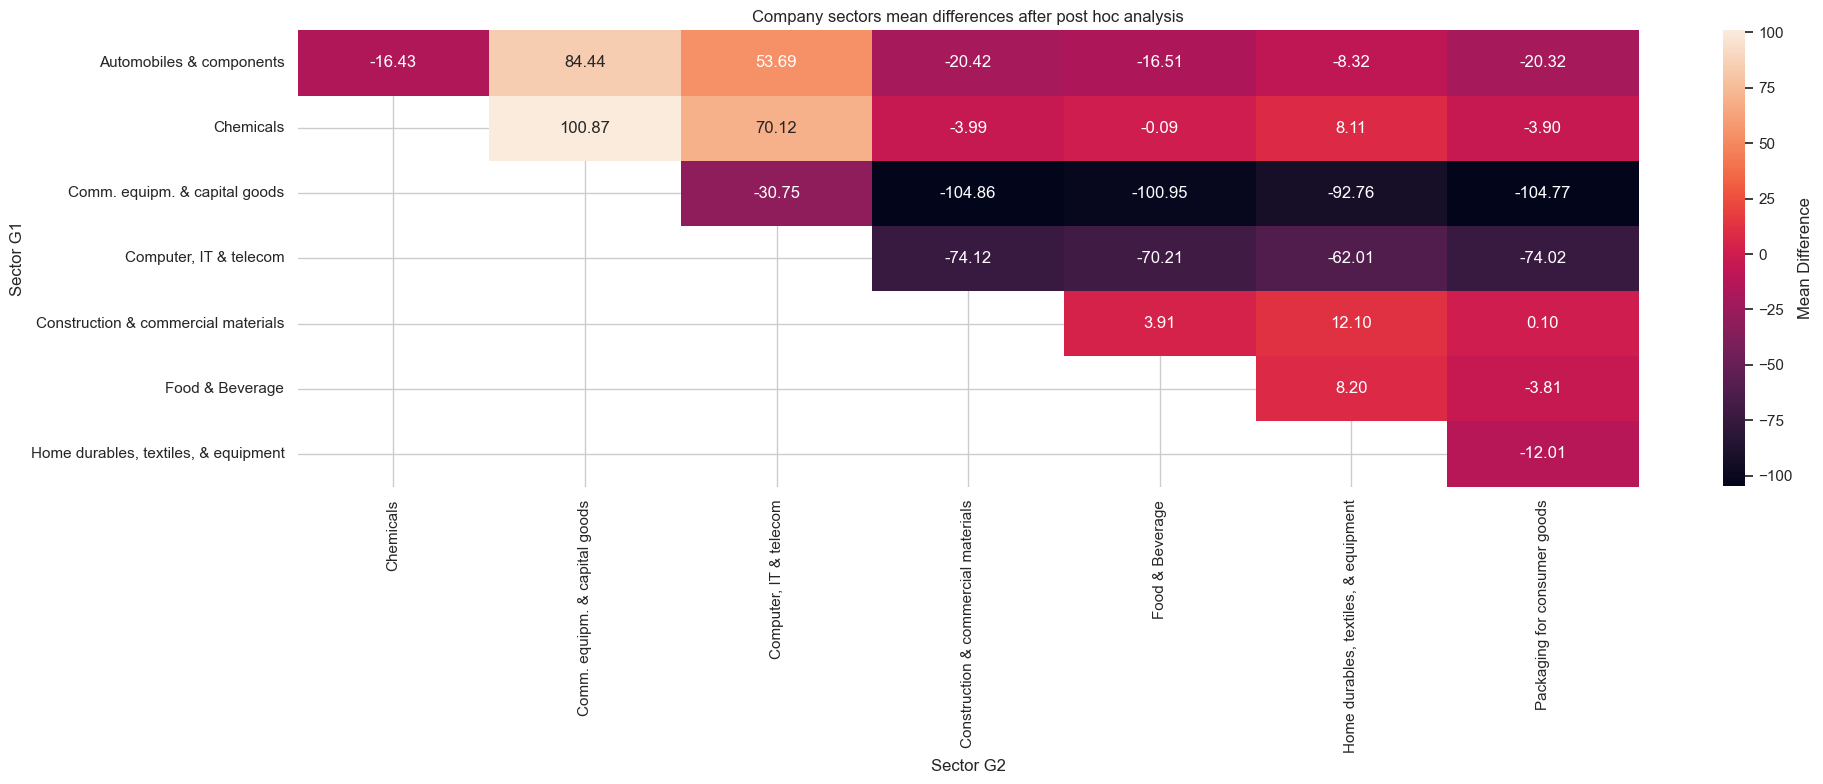

In [13]:
# Aggregate duplicates by mean
ci_df_sorted = ci_df_sorted.groupby(['group1', 'group2'], as_index=False).agg({'meandiff': 'mean'})
top_200 = ci_df_sorted.nlargest(200, 'meandiff', keep='all')
# Create a pivot table for the heatmap
heatmap_ci_data = ci_df_sorted.pivot(index='group1', columns='group2', values='meandiff')

plt.figure(figsize=(20, 8))
sns.heatmap(
    heatmap_ci_data, 
    annot=True, 
    fmt=".2f", 
    cbar_kws={'label': 'Mean Difference'}
)
plt.title('Company sectors mean differences after post hoc analysis')
plt.xlabel('Sector G2')
plt.ylabel('Sector G1')
plt.tight_layout()
plt.show()

### Conclusion:
The results from the Tukey HSD test and the corresponding heatmap highlight several significant pairwise differences in carbon intensity (CI) between sectors. Among these, the following sector pairs exhibit the highest CI differences, with values exceeding 90:

* Comm. Equipm. & Capital Goods → Construction & Commercial Materials = 104.86
* Comm. Equipm. & Capital Goods → Food & Beverage = 100.95
* Comm. Equipm. & Capital Goods → Home Durables, Textiles, & Equipment = 92.76
* Comm. Equipm. & Capital Goods → Packaging for Consumer Goods = 104.77
  
These values are marked by the same color (dark black) in the heatmap, indicating that these sector pairs have the most significant differences in their carbon intensity levels.

This suggests that sectors such as Comm. Equipm. & Capital Goods and Construction & Commercial Materials, Food & Beverage, and Packaging for Consumer Goods have considerable divergence in their environmental performance. The high CI differences could be attributed to industry-specific factors such as production methods, energy usage, and supply chain practices.

#### Sectors with Overlapping CI Ranges:
* Comm. Equipm. & Capital Goods and Packaging for Consumer Goods: The CI difference between these two sectors is relatively small (104.77) compared to others. This suggests that their CI ranges may overlap significantly, making it challenging to distinguish their carbon intensity levels based purely on the heatmap visualization.
* Comm. Equipm. & Capital Goods and Home Durables, Textiles, & Equipment: With a CI difference of 92.76, these sectors also exhibit a degree of overlap in their CI values, indicating that they might have similar environmental performance in terms of carbon intensity.


### Implications:
* Environmental Impact: The substantial differences in CI between these sectors emphasize the need for tailored sustainability strategies and interventions. Sectors with high CI values, such as Food & Beverage and Packaging for Consumer Goods, may require more stringent measures to reduce their environmental impact.  
* Further Analysis: The similar color patterns in the heatmap suggest that sectors like Comm. Equipm. & Capital Goods and Construction & Commercial Materials exhibit particularly high variability, warranting deeper exploration of their production processes, technologies, and resource usage to understand the root causes of these differences.


### Possible Reasons for the Differences in Carbon Intensity (CI):
* Energy Usage: Sectors like Food & Beverage and Chemicals are more energy-intensive, leading to higher CI, while sectors like IT & Telecom and Packaging for Consumer Goods use less energy.

* Technology & Efficiency: Sectors with advanced technologies and energy-efficient systems (e.g., Comm. Equipm. & Capital Goods) tend to have lower CI.

* Regulation & Sustainability: Stricter environmental regulations in some sectors promote lower CI, whereas others, like Food & Beverage, may lack such incentives.

* Waste Management: Sectors with poor waste management and high waste generation often show higher CI, whereas those with better recycling systems show lower CI.

* Geography: CI is influenced by the region’s energy mix, with areas relying on fossil fuels having higher CI values.

# Part 2: Comparing the carbon intensity across countries/country-groups

#### Objectives: 

- Calculate the average CI with respect to all countries, or group countries in a logical way if neccesary 
- examine if the assumptions for statistical tests hold true (e.g. normal distribution for ANOVA)
- conduct statistical test to find out whether there are significant differences between countries/groups of countries 
- formulate hypothesis regarding the reasons for differences if any 


##### Step one: Loading and checking the data set
- **Objective:** Load the first sheet of the dataset and perform basic quality checks.
- **Steps:**
  1. Load the first worksheet into a DataFrame using `pandas`.
  2. Display an overview of the dataset (first few rows, data types, missing values, unique values, summary statistics).
- **Purpose:** Ensure the dataset is ready for analysis and identify any immediate issues like missing data or unexpected values.

In [14]:

# Load the Excel file

file_path=r'PublicTablesForCarbonCatalogueDataDescriptor_v30Oct2021.xlsx'
data = pd.ExcelFile(file_path)

# Load the first sheet into a DataFrame
main_data = data.parse(data.sheet_names[0])  # Load only the first sheet

# Display the first few rows
print("Preview of the first few rows of the dataset:")
display(main_data.head())


Preview of the first few rows of the dataset:


,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,Product weight (kg),*Source for product weight,"Product's carbon footprint (PCF, kg CO2e)",*Carbon intensity,Protocol used for PCF,Relative change in PCF vs previous,Company-reported reason for change,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any)
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,0.7485,Estimated from external data based on product ...,2.00,2.67,Not reported,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,0.7485,Estimated from external data based on product ...,2.00,2.67,Not reported,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,20.6800,Estimated from external data based on product ...,72.54,3.51,Not reported,(not reported by company),N/a,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c..."
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",110.0000,Estimated from external data based on product ...,1488.00,13.53,ISO,(not reported by company),N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",110.0000,Estimated from external data based on product ...,1818.00,16.53,ISO,(not reported by company),N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN


##### Step two: Understanding the distribution of values across countries
- **Objective:** Determine the unique countries in the dataset and visualize the number of entries per country.
- **Steps:**
  1. Use `value_counts()` to count occurrences of each unique country in the `Country` column.
  2. Display the counts for clarity.
  3. Create a bar plot to visualize the frequency of entries for each country.
- **Purpose:** Understand the geographic distribution of the data, which can help identify any imbalances or regional trends.




Number of unique countries and their respective counts:


Country (where company is incorporated)
USA               305
Japan             110
Germany            67
Taiwan             60
Netherlands        35
Finland            35
United Kingdom     32
Switzerland        28
Sweden             26
Italy              23
South Korea        22
France             20
Brazil             17
India              16
Spain              13
South Africa       11
Belgium             8
China               6
Canada              6
Ireland             6
Australia           6
Malaysia            4
Chile               3
Colombia            2
Luxembourg          2
Lithuania           1
Indonesia           1
Greece              1
Name: count, dtype: int64

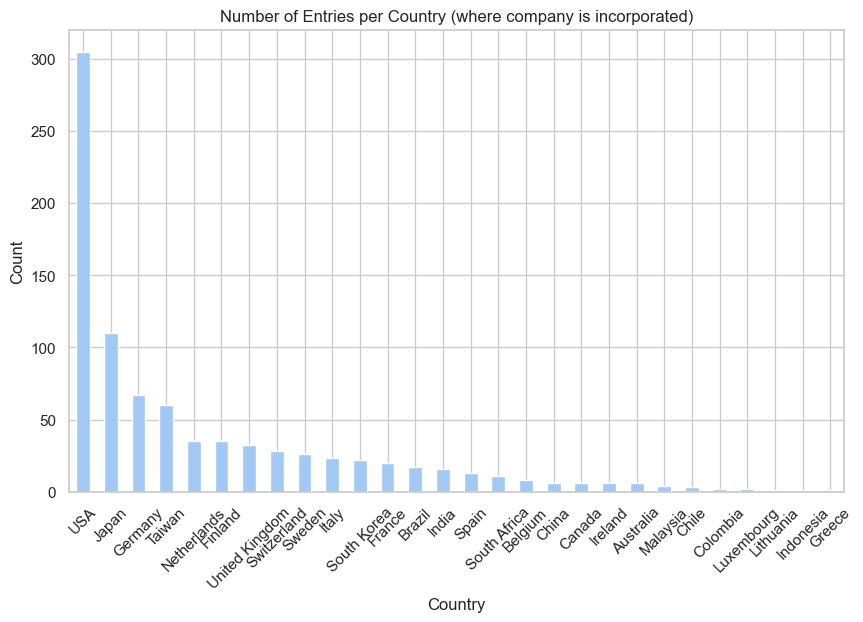

In [15]:
# Identify unique countries and their counts
print("Number of unique countries and their respective counts:")
country_counts = main_data['Country (where company is incorporated)'].value_counts()
display(country_counts)

# Plot the counts as a bar plot
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.title('Number of Entries per Country (where company is incorporated)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


##### Interpretation: 

- One can already see that we will run into issues when using statistical test like ANOVA, since the distribution between is very uneven. While USA, Japan, Germany and Taiwan have a lot of values. However, Greece, Indonesia and others have only few values.
- We could drop all countries with less than 30 values, but that would shrink the information density in the data set. A better alternative would be to group the countries logically. 
- Since we do not know where the clients of EcoFuture Analytics are situated, we can not really estimate which countries are most imporant with respect to our clients. One could assume that most clients will be situated in the biggest economies in the dataset (USA, Japan, Germany) and all other countries will be "slightly" less important. 
- Therefore we could build groups of countries, if they have less than 30 values by allocating them to their respective geographic reason.

### Step three: Building bigger groups
- **Objective:** Group countries with fewer than 30 entries into regional categories (e.g., "Europe Others") while preserving countries with 30 or more entries.
- **Steps:**
  1. Map each country to a continent using a predefined dictionary.
  2. Countries with fewer than 30 entries are assigned to their continent-specific "Others" group.
  3. Display the new distribution and visualize it in a bar plot.
- **Purpose:** Ensure statistically meaningful group sizes for ANOVA, while maintaining logical geographic groupings.



New group distribution:


Grouped Country
USA                     305
Japan                   110
Europe Others            74
Germany                  67
Taiwan                   60
Asia Others              49
Netherlands              35
Finland                  35
United Kingdom           32
Switzerland              28
Sweden                   26
South America Others     22
Africa Others            11
North America Others      6
Oceania Others            6
Name: count, dtype: int64

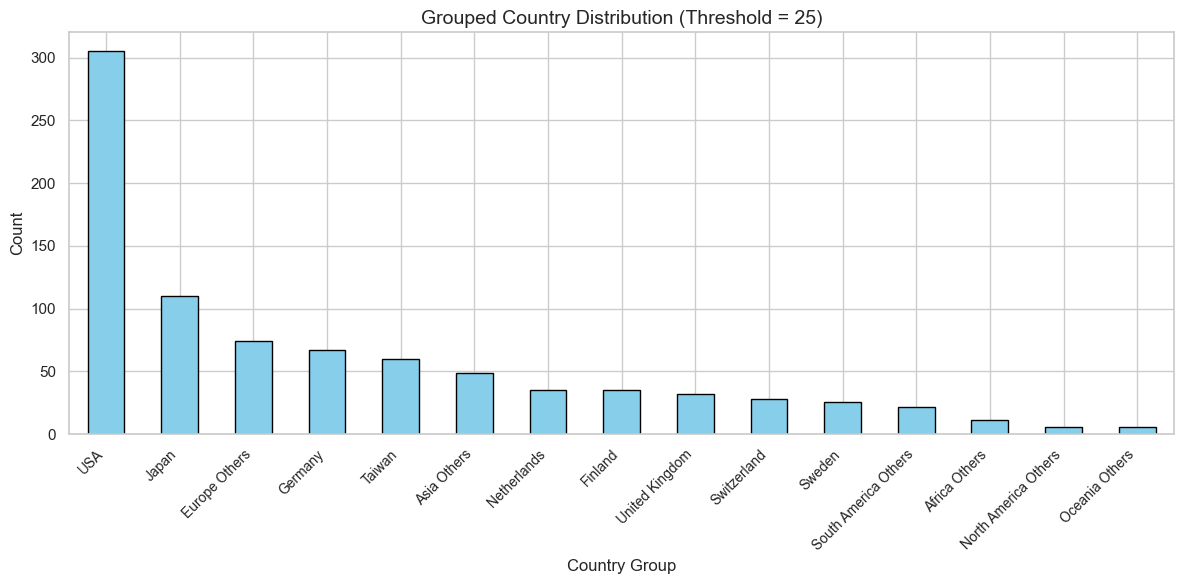

In [16]:
# Define the threshold for grouping
threshold = 25

# Define a mapping for countries to continents
continent_mapping = {
    'USA': 'North America',
    'Japan': 'Asia',
    'Germany': 'Europe',
    'Taiwan': 'Asia',
    'Netherlands': 'Europe',
    'Finland': 'Europe',
    'United Kingdom': 'Europe',
    'Switzerland': 'Europe',
    'Sweden': 'Europe',
    'Italy': 'Europe',
    'South Korea': 'Asia',
    'France': 'Europe',
    'Brazil': 'South America',
    'India': 'Asia',
    'Spain': 'Europe',
    'South Africa': 'Africa',
    'Belgium': 'Europe',
    'China': 'Asia',
    'Canada': 'North America',
    'Ireland': 'Europe',
    'Australia': 'Oceania',
    'Malaysia': 'Asia',
    'Chile': 'South America',
    'Colombia': 'South America',
    'Luxembourg': 'Europe',
    'Lithuania': 'Europe',
    'Indonesia': 'Asia',
    'Greece': 'Europe'
}

# Create a new column with grouped countries
def group_countries(country):
    count = country_counts.get(country, 0)
    if count >= threshold:
        return country
    else:
        continent = continent_mapping.get(country, 'Other')
        return f"{continent} Others"

main_data['Grouped Country'] = main_data['Country (where company is incorporated)'].apply(group_countries)

# Verify the new group distribution
print("New group distribution:")
group_distribution = main_data['Grouped Country'].value_counts()
display(group_distribution)

# Plot the new group distribution with adjusted label alignment
plt.figure(figsize=(12, 6))
group_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Grouped Country Distribution (Threshold = 25)', fontsize=14)
plt.xlabel('Country Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and align labels to the right
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



##### Interpretation 

- This approach creates bigger groups.
- Still some groups are very small. When interpretating the results in the end, we should be aware, that those groups are to small in terms of values. So interpretation with respect to those groups will be limited

#### Step four: Checking core assumptions for statistical tests like ANOVA
- **Objective:** Assess the data properties for statistical tests related to the `Carbon intensity` column.
- **Steps:**
  1. **Boxplots:** Visualize the distribution of `Carbon intensity` for each group to check for similar variance and normality.
  2. **Residuals:**
     - Calculate residuals by subtracting the overall mean from each observation in `Carbon intensity`.
     - Plot a histogram of these residuals to check for the normality of the entire model.
  3. **Group Residuals:**
     - Group the residuals by country and plot histograms side by side to assess the normality within each group.
- **Purpose:** Ensure the data meets the assumptions for statistical tests such as ANOVA, including similar variances and normality of residuals.


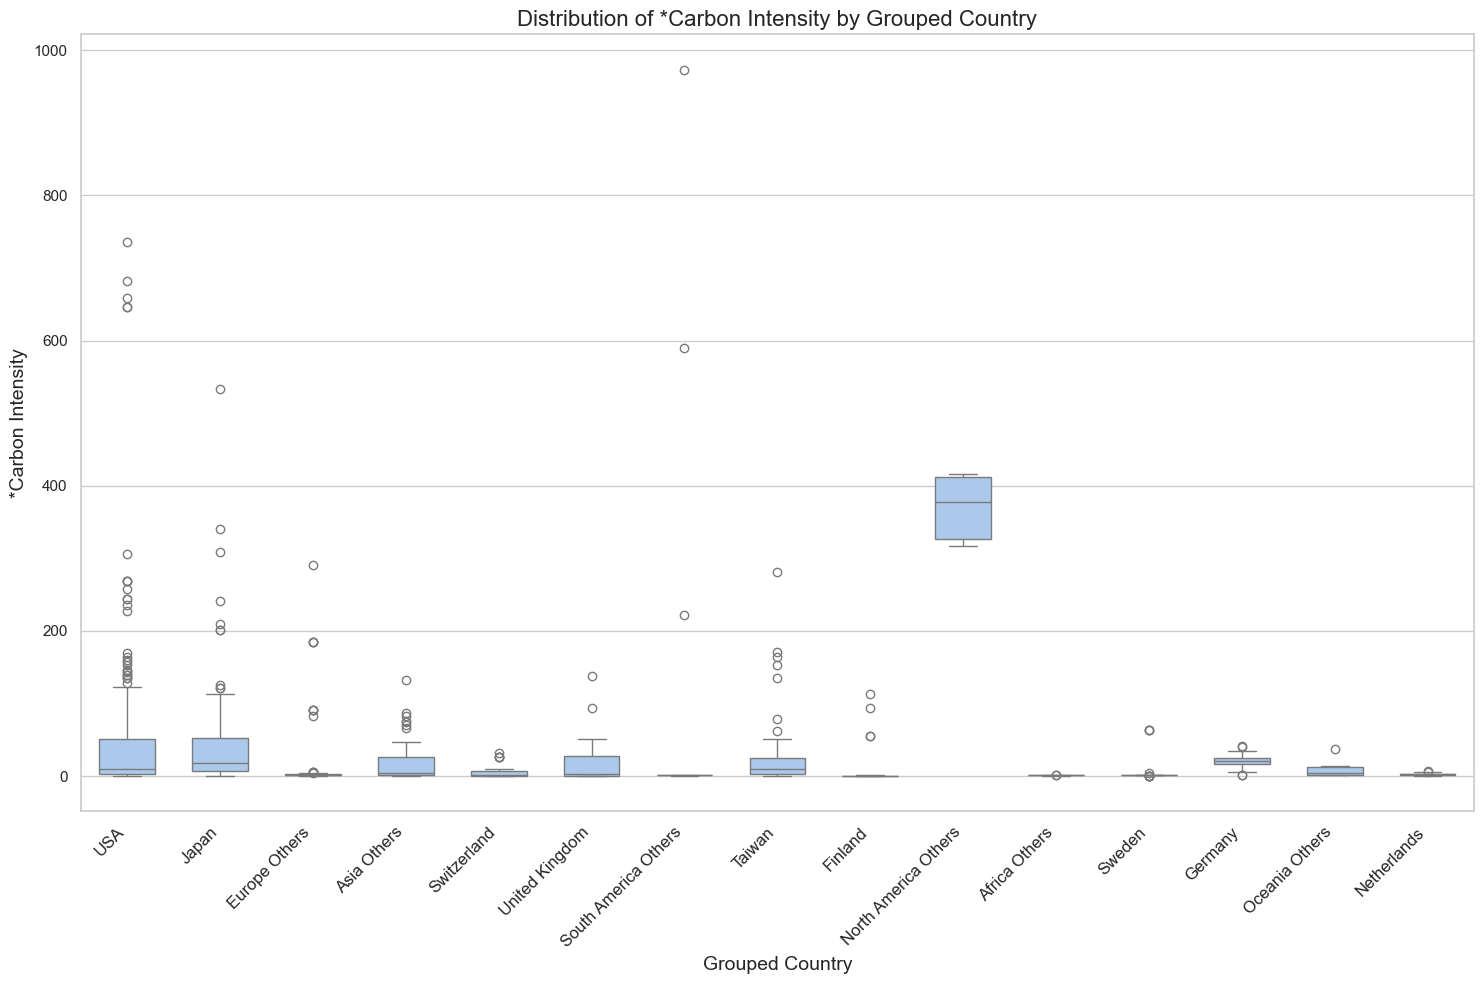

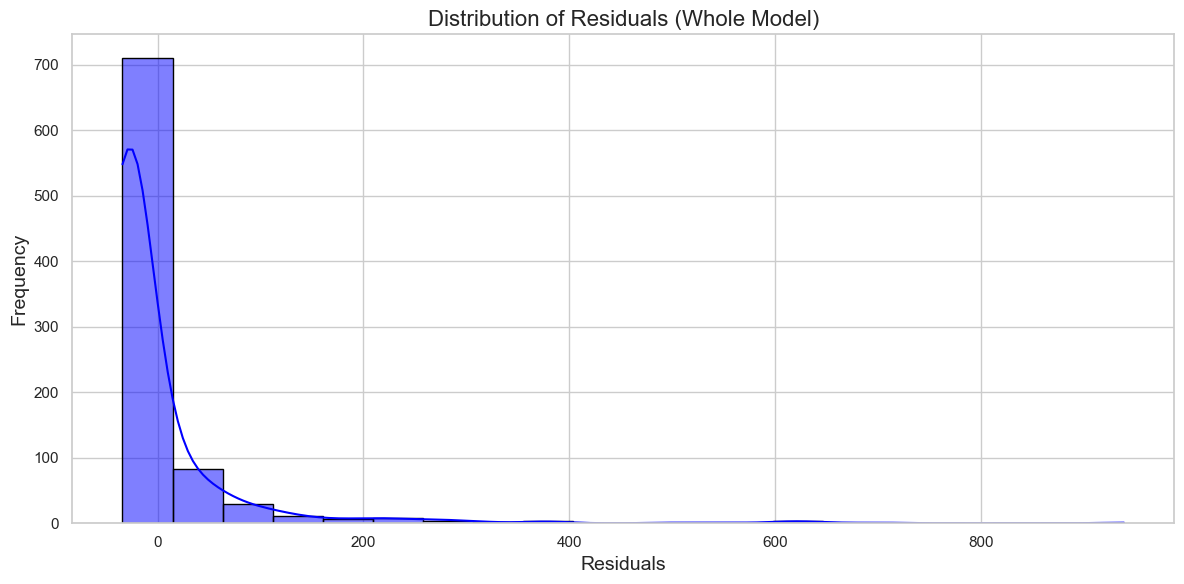

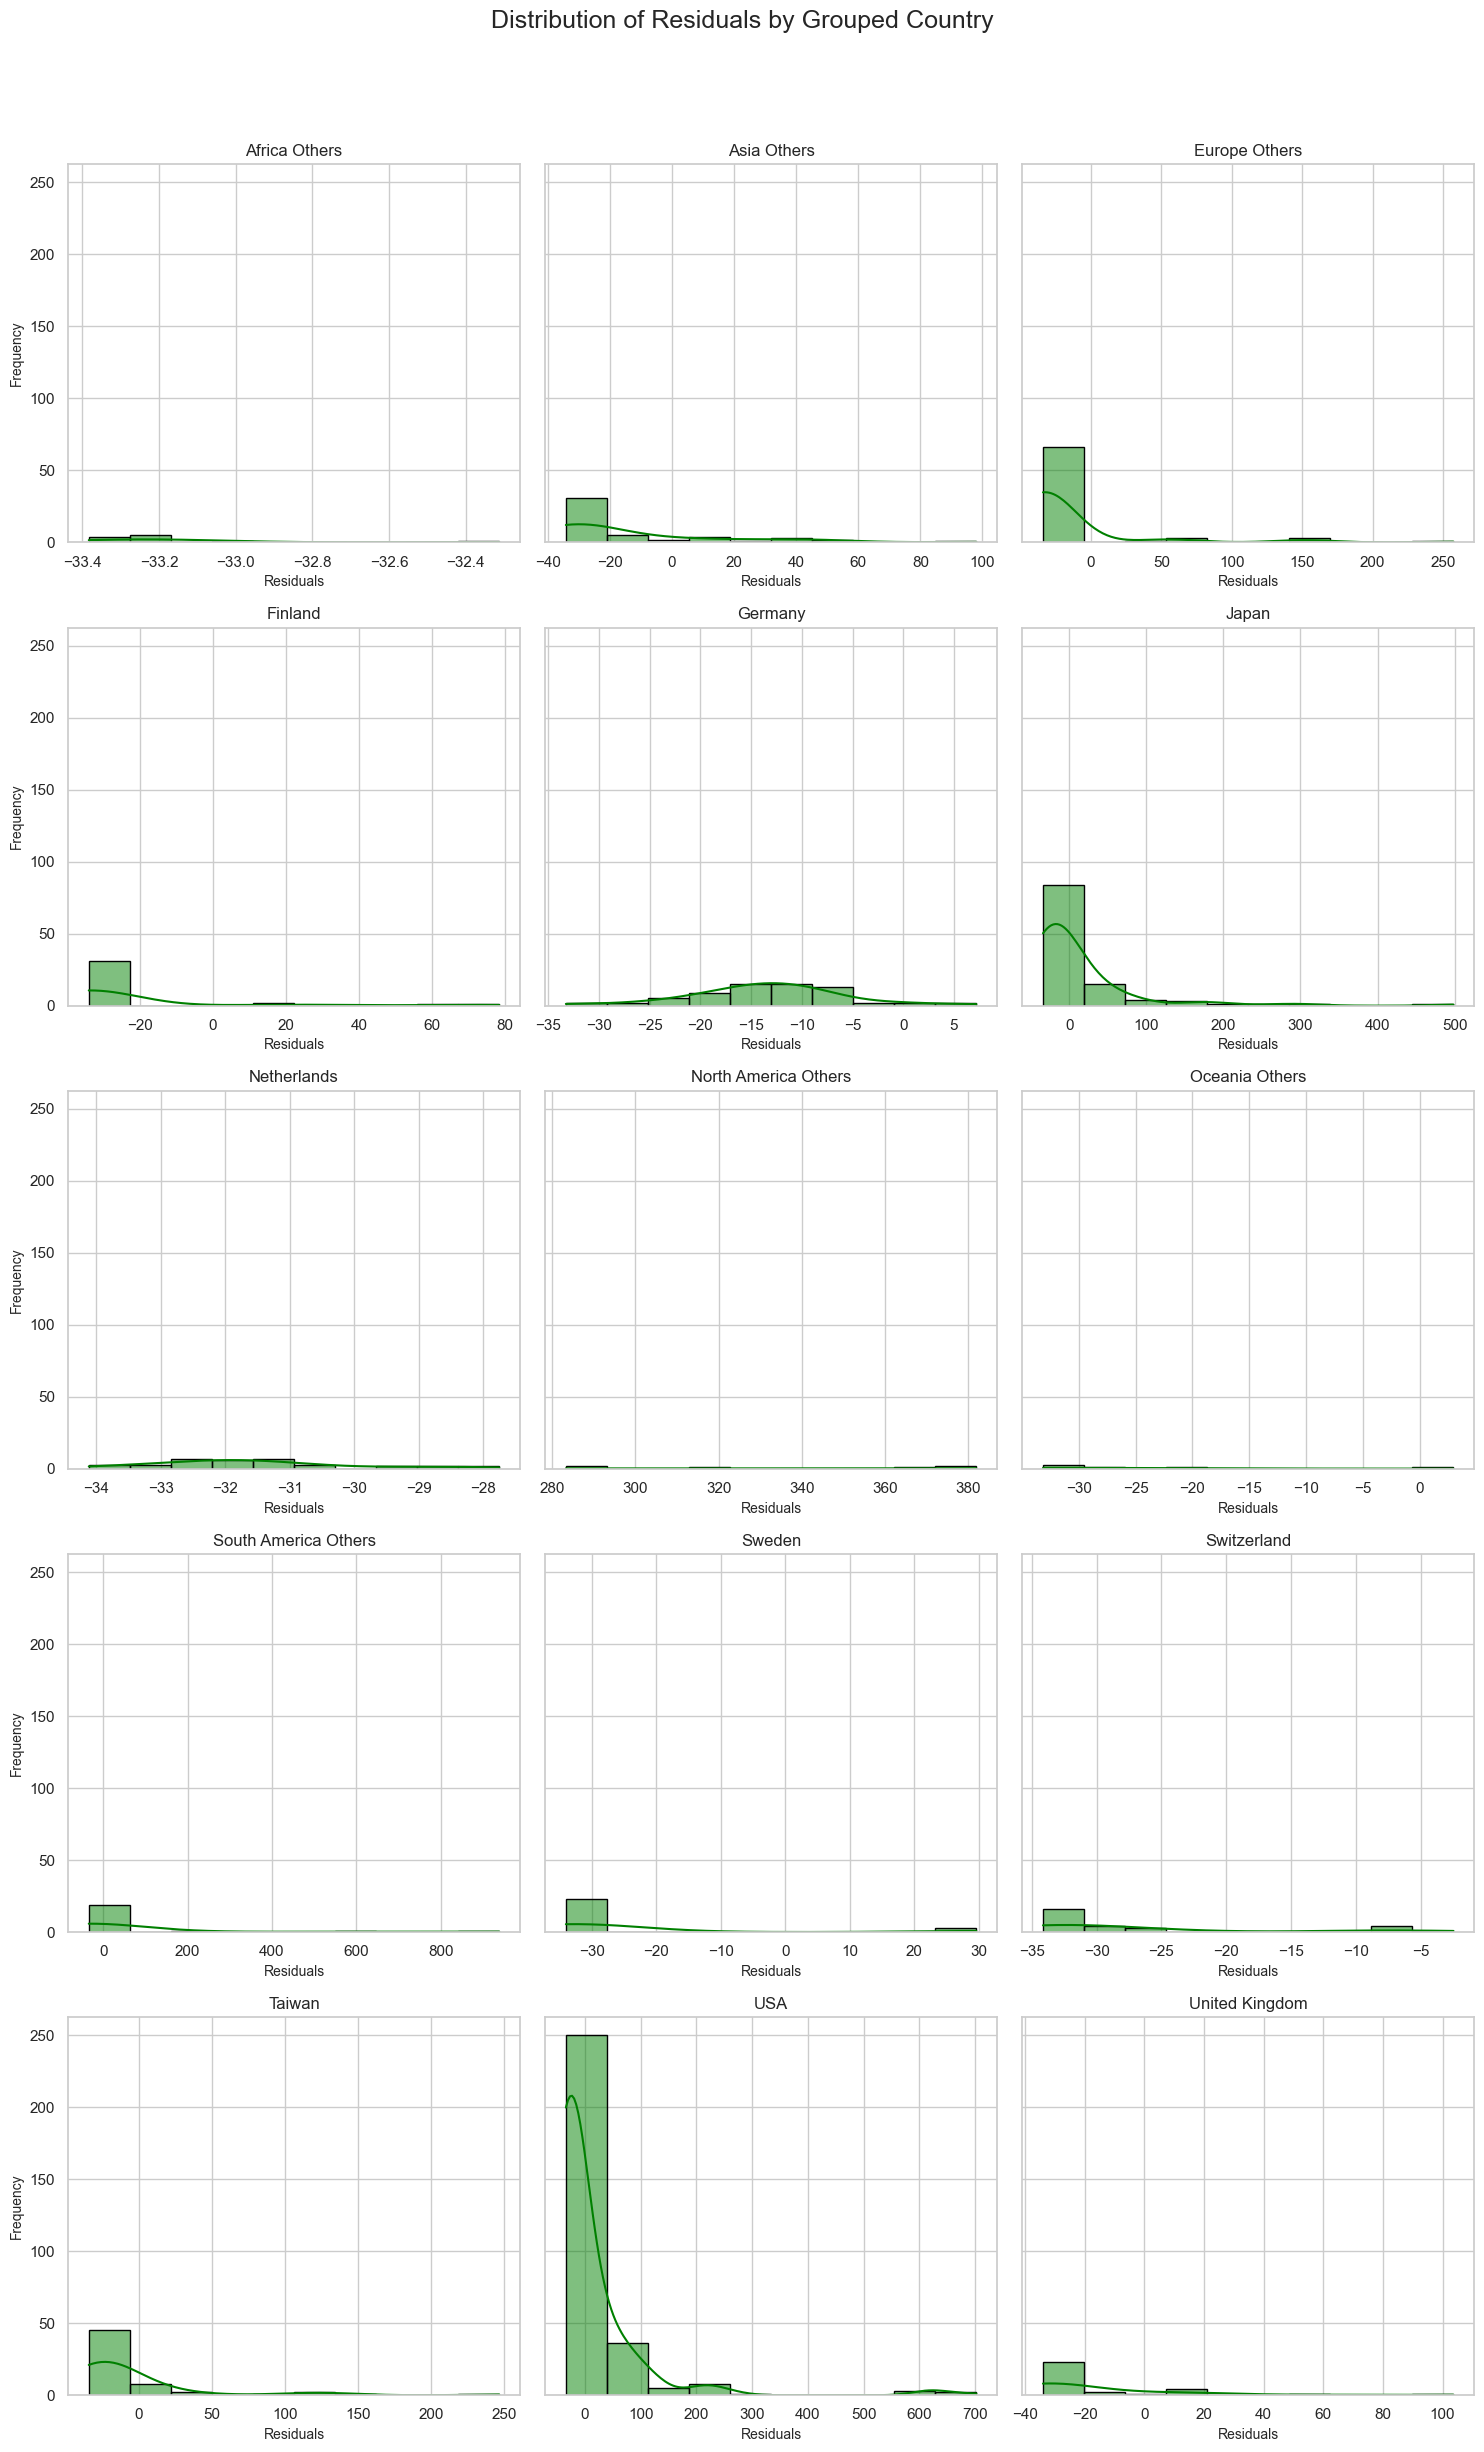

Summary table of each group's statistics:


,Grouped Country,mean,variance,std_dev
0,Africa Others,1.106364,0.084665,0.290973
1,Asia Others,20.764490,919.639421,30.325557
2,Europe Others,17.612838,2699.850903,51.960090
3,Finland,9.669714,716.462068,26.766809
4,Germany,20.763582,58.250648,7.632211
5,Japan,44.831364,5813.141783,76.243962
6,Netherlands,2.706571,2.529206,1.590348
7,North America Others,370.148333,2193.847657,46.838527
8,Oceania Others,10.500000,198.753560,14.097998
9,South America Others,82.125455,56941.583626,238.624357


In [17]:
# Check if the required column exists
if '*Carbon intensity' not in main_data.columns:
    print("The column '*Carbon intensity' is missing from the dataset.")
else:
    # Boxplot: Distribution of Carbon Intensity for each group
    plt.figure(figsize=(15, 10))  # Increased figure size
    sns.boxplot(data=main_data, x='Grouped Country', y='*Carbon intensity', width=0.6)
    plt.title('Distribution of *Carbon Intensity by Grouped Country', fontsize=16)
    plt.xlabel('Grouped Country', fontsize=14)
    plt.ylabel('*Carbon Intensity', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Calculate residuals for the whole model
    overall_mean = main_data['*Carbon intensity'].mean()
    main_data['Residuals'] = main_data['*Carbon intensity'] - overall_mean

    # Histogram: Residuals of the whole model
    plt.figure(figsize=(12, 6))  # Increased figure size
    sns.histplot(main_data['Residuals'], kde=True, bins=20, color='blue', edgecolor='black')
    plt.title('Distribution of Residuals (Whole Model)', fontsize=16)
    plt.xlabel('Residuals', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Histogram: Residuals for each group
    grouped_residuals = main_data.groupby('Grouped Country')['Residuals']

    # Adjusted layout for individual group histograms
    n_groups = len(grouped_residuals)
    n_cols = 3  # Number of columns for the grid
    n_rows = (n_groups + n_cols - 1) // n_cols  # Calculate required rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharey=True)
    fig.suptitle('Distribution of Residuals by Grouped Country', fontsize=18)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for i, (group, residuals) in enumerate(grouped_residuals):
        sns.histplot(residuals, kde=True, bins=10, color='green', edgecolor='black', ax=axes[i])
        axes[i].set_title(group, fontsize=12)
        axes[i].set_xlabel('Residuals', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for title space
    plt.show()

    # Summary table: mean, variance, and standard deviation for each group
    summary_table = main_data.groupby('Grouped Country')['*Carbon intensity'].agg(
        mean='mean',
        variance='var',
        std_dev='std'
    ).reset_index()

    print("Summary table of each group's statistics:")
    display(summary_table)


##### Interpretation 

- Test for homogenity of variances: variances differ a lot, so this assumption is violated 
- Test for normality of residuals: nearly all distributions in the groups are highly skewed. This assumption is also violated. 
- additionally the sample size between groups still differs significantly 
- We will have to proceed with a different statistical test than the "normal" ANOVA
- One could now decide to group differently for example by continent. But then the information density will be shrinked a lot. 
- Furthermore we can also see that the mean between groups is highly different, with North America (excluding the USA) in first position. 

##### Step five: Checking for significant differences
- **Objective:** Perform Welch's ANOVA to test for significant differences in the means of `*Carbon intensity` across groups, accounting for unequal variances and group sizes.
- **Steps:**
  1. **Data Preparation:** Filter the dataset to include only `Grouped Country` (independent variable) and `*Carbon intensity` (dependent variable). Remove rows with missing values to ensure valid calculations.
  2. **Model Fitting:** Use the ordinary least squares (OLS) model to estimate group means and variances.
     - Apply the `robust='hc3'` option to correct for heteroscedasticity (unequal variances).
  3. **Welch’s ANOVA Test:** Conduct the ANOVA test using the fitted model and extract the p-value to determine statistical significance.
- **Purpose:** Welch’s ANOVA is a robust alternative to traditional ANOVA, suitable for datasets with unequal variances and/or group sizes.


In [18]:
# Ensure the required column exists
if '*Carbon intensity' not in main_data.columns:
    print("The column '*Carbon intensity' is missing from the dataset.")
else:
    # Step 1: Prepare the data and rename columns
    clean_data = main_data[['Grouped Country', '*Carbon intensity']].dropna()
    clean_data = clean_data.rename(columns={
        '*Carbon intensity': 'Carbon_intensity', 
        'Grouped Country': 'Grouped_Country'
    })

    # Step 2: Perform Welch’s ANOVA
    formula = 'Carbon_intensity ~ C(Grouped_Country)'  # Match renamed columns
    model = ols(formula, data=clean_data).fit()
    welch_anova = sm.stats.anova_lm(model, typ=2, robust='hc3')  # Use robust HC3 for heteroscedasticity
    print("Welch's ANOVA Results:")
    display(welch_anova)

    # Step 3: Interpret the Results
    # Use .iloc[0] to access the first p-value by position
    p_value = welch_anova['PR(>F)'].iloc[0]
    if p_value < 0.05:
        print(f"Significant differences found between groups (p = {p_value:.4f}).")
    else:
        print(f"No significant differences found between groups (p = {p_value:.4f}).")


Welch's ANOVA Results:


,sum_sq,df,F,PR(>F)
C(Grouped_Country),5.760656e+06,14.0,66.647689,2.907430e-126
Residual,5.253979e+06,851.0,NaN,NaN


Significant differences found between groups (p = 0.0000).


##### Intrepration: 

- Welch's ANOVA shows that the differences between groups are significant. This is not surprising because we could already see that in the boxplot. 

##### Step six: Examining differences between groups
- **Objective:** Compare how groups differ from each other after Welch's ANOVA by performing a pairwise comparison.
- **Method:** Use the **Games-Howell post-hoc test**, which is robust to unequal variances and group sizes.
- **Steps:**
  1. **Data Preparation:**
     - Filter the dataset to include only the dependent variable (`*Carbon intensity`) and the grouping variable (`Grouped Country`).
     - Rename columns to avoid issues with special characters or spaces.
  2. **Perform Games-Howell Test:**
     - Use the `pairwise_gameshowell()` function from the `pingouin` library to compare all possible pairs of groups.
     - Compute p-values for each pairwise comparison, adjusted for Type I error.
  3. **Display Results:**
     - The results table shows mean differences, standard errors, test statistics, and adjusted p-values.

In [19]:
# Ensure the required column exists
if '*Carbon intensity' not in main_data.columns:
    print("The column '*Carbon intensity' is missing from the dataset.")
else:
    # Step 1: Prepare the data and rename columns
    clean_data = main_data[['Grouped Country', '*Carbon intensity']].dropna()
    clean_data = clean_data.rename(columns={
        '*Carbon intensity': 'Carbon_intensity',
        'Grouped Country': 'Grouped_Country'
    })

    # Step 2: Perform the Games-Howell test
    posthoc_results = pg.pairwise_gameshowell(
        data=clean_data,
        dv='Carbon_intensity',   # Dependent variable
        between='Grouped_Country'  # Independent variable (grouping)
    )

    # Step 3: Display the results
    print("Games-Howell Post-Hoc Test Results:")
    display(posthoc_results)


Games-Howell Post-Hoc Test Results:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Africa Others,Asia Others,1.106364,20.764490,-19.658126,4.333111,-4.536724,48.039339,3.098933e-03,-0.703308
1,Africa Others,Europe Others,1.106364,17.612838,-16.506474,6.040875,-2.732464,73.030780,3.071073e-01,-0.335666
2,Africa Others,Finland,1.106364,9.669714,-8.563351,4.525267,-1.892342,34.025556,8.409098e-01,-0.357698
3,Africa Others,Germany,1.106364,20.763582,-19.657218,0.936541,-20.989165,67.139032,0.000000e+00,-2.736134
4,Africa Others,Japan,1.106364,44.831364,-43.725000,7.270106,-6.014355,109.031728,2.501564e-06,-0.595433
...,...,...,...,...,...,...,...,...,...,...
100,Switzerland,USA,6.869286,45.086623,-38.217337,5.947338,-6.425957,329.158131,4.799881e-08,-0.404065
101,Switzerland,United Kingdom,6.869286,17.763125,-10.893839,5.916737,-1.841190,37.960991,8.661228e-01,-0.444910
102,Taiwan,USA,29.098000,45.086623,-15.988623,8.674435,-1.843189,160.088809,8.765225e-01,-0.172689
103,Taiwan,United Kingdom,29.098000,17.763125,11.334875,8.653483,1.309863,87.820709,9.920746e-01,0.247863


In [20]:
# Filter results where p-value is significant
significant_results = posthoc_results[posthoc_results['pval'] < 0.05]
print("Significant Pairwise Comparisons:")
display(significant_results)


Significant Pairwise Comparisons:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Africa Others,Asia Others,1.106364,20.764490,-19.658126,4.333111,-4.536724,48.039339,3.098933e-03,-0.703308
3,Africa Others,Germany,1.106364,20.763582,-19.657218,0.936541,-20.989165,67.139032,0.000000e+00,-2.736134
4,Africa Others,Japan,1.106364,44.831364,-43.725000,7.270106,-6.014355,109.031728,2.501564e-06,-0.595433
5,Africa Others,Netherlands,1.106364,2.706571,-1.600208,0.282772,-5.659008,40.082453,1.270075e-04,-1.119526
6,Africa Others,North America Others,1.106364,370.148333,-369.041970,19.121950,-19.299390,5.000211,1.470025e-04,-12.952464
11,Africa Others,Taiwan,1.106364,29.098000,-27.991636,6.594856,-4.244465,59.020877,6.244861e-03,-0.586164
12,Africa Others,USA,1.106364,45.086623,-43.980259,5.636407,-7.802889,304.146814,1.040190e-11,-0.453051
18,Asia Others,Netherlands,20.764490,2.706571,18.057918,4.340555,4.160279,48.369328,9.690883e-03,0.770406
19,Asia Others,North America Others,20.764490,370.148333,-349.383844,19.606362,-17.819922,5.524951,1.048967e-04,-10.680678
31,Europe Others,North America Others,17.612838,370.148333,-352.535495,20.053073,-17.580123,6.043483,5.605603e-05,-6.760019


##### Interpretation 

- this table is only helpful if there are specific cases where a client wants to know if there is a significant difference between pairwise groups.
- We can see that a lot of pairs differ significantly between each other. We can also see the respective means, which makes it really clear. 

### Overall Interpretation for policy makers and limitations

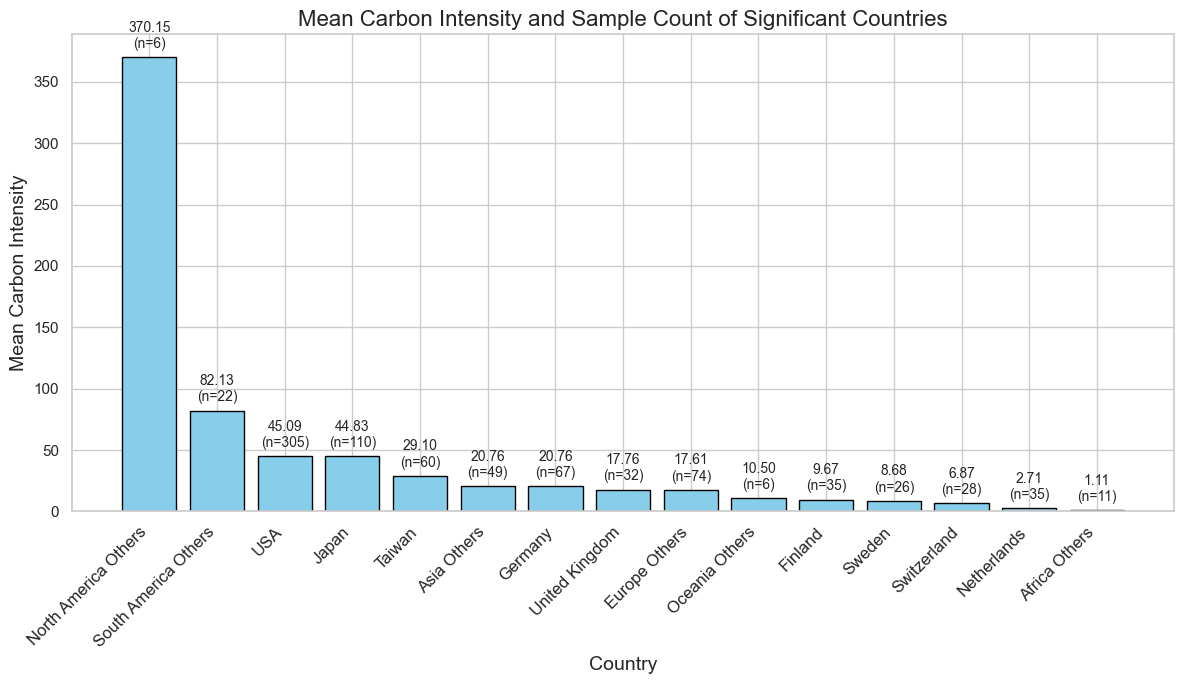

In [21]:
# Step 1: Filter significant results
significant_results = posthoc_results[posthoc_results['pval'] < 0.05]

# Step 2: Extract unique countries from significant comparisons
unique_countries = set(significant_results['A']).union(set(significant_results['B']))

# Step 3: Calculate means and counts for these countries
country_means = clean_data.groupby('Grouped_Country')['Carbon_intensity'].mean()
country_counts = clean_data.groupby('Grouped_Country')['Carbon_intensity'].count()

# Step 4: Filter and sort the means and counts for only the significant countries
significant_means = country_means[country_means.index.isin(unique_countries)].sort_values(ascending=False)
significant_counts = country_counts[significant_means.index]

# Step 5: Plot the means as a bar chart
plt.figure(figsize=(12, 7))
bars = plt.bar(significant_means.index, significant_means.values, color='skyblue', edgecolor='black')

# Add value labels to each bar
for bar, count in zip(bars, significant_counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center the text on the bar
        height + 5,  # Slightly above the bar
        f'{height:.2f}\n(n={count})',  # Format to include mean and count
        ha='center', va='bottom', fontsize=10
    )

# Add chart details
plt.title('Mean Carbon Intensity and Sample Count of Significant Countries', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Mean Carbon Intensity', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()


### Key Findings and Limitations

#### Significant Differences Across Groups:
- **Welch’s ANOVA** confirmed that there are significant differences in *Carbon Intensity* between groups (p-value from ANOVA).
- The post-hoc analysis revealed specific pairwise differences, with **37 significant comparisons** (p < 0.05).

#### Groups with High Differences:
- **North America Others** stands out as a major outlier, consistently showing significantly higher *Carbon Intensity* compared to almost all other groups (e.g., Netherlands, Japan, Oceania Others).
- **USA, Japan, and Germany** also display relatively high *Carbon Intensity*, with significant differences compared to lower-intensity groups like **Netherlands, Switzerland, and Sweden**.
- Groups like **Africa Others, Oceania Others, and Switzerland** generally show low *Carbon Intensity* and are often significantly different from high-intensity groups.

---

### 2. Possible Reasons for the Differences

#### a. Industrialization Level and Energy Mix
- **North America Others and USA:**
  - Likely reflects high-carbon industries and reliance on fossil fuels for energy.
  - Large-scale industrial activities, including resource extraction and manufacturing, drive high emissions.
- **Europe Others, Netherlands, and Switzerland:**
  - Lower *Carbon Intensity* may result from cleaner energy sources (e.g., renewables, nuclear) and stringent environmental regulations.

#### b. Nature of Products
- High-intensity regions may focus on producing energy-intensive goods, such as heavy machinery, automobiles, or chemicals.
- Low-intensity regions may produce less energy-demanding goods, such as textiles or services.

#### c. Regulations and Sustainability Initiatives
- **Europe (e.g., Germany, Netherlands):**
  - Stringent regulations on emissions and higher adoption of energy-efficient technologies may lower *Carbon Intensity*.
- **Developing regions (e.g., Africa Others):**
  - Limited industrial activities and cleaner supply chains contribute to lower intensity but may also reflect lower economic output.

#### d. Economic Development Stage
- **Developed regions (e.g., USA, Japan):**
  - Higher industrial activity and energy demand, leading to higher emissions.
- **Developing regions (e.g., Africa Others):**
  - Fewer emissions due to limited industrialization.

---

### 3. Strategic Insights

#### Regions Requiring Attention:
- **North America Others, USA, and Japan** should be targeted for carbon reduction strategies, as they consistently show high *Carbon Intensity*.
- These regions may benefit from:
  - Transitioning to renewable energy.
  - Implementing stricter emissions standards.
  - Encouraging carbon offset programs.

#### Benchmarks for Low Emissions:
- Groups like **Netherlands, Switzerland, and Sweden** demonstrate significantly lower *Carbon Intensity* and could serve as benchmarks for sustainability practices.

---

### 4. Challenges in Interpretation

#### Aggregate Data:
- The analysis uses aggregate data per region, which may mask intra-regional variations (e.g., emissions vary across states or industries).
- The decision for one approach of grouping the countries may have an significant influence on the output. 

#### Underlying Factors Not Captured:
- Factors such as trade, raw material sourcing, and supply chain complexity are not directly analyzed but may influence *Carbon Intensity*.

---

### Overall Interpretation

#### Big Picture:
- The results confirm that *Carbon Intensity* varies significantly between regions, driven by differences in industrial activity, energy sources, and regulations.

#### Actionable Insights:
- High-emission groups like **North America Others** and **USA** require immediate intervention, while low-emission regions like **Switzerland** and **Netherlands** offer valuable models for sustainable practices.
```

# Part 3. Value Chain Contribution to Carbon Intensity

In [22]:
# Convert relevant columns to numeric (such as emissions data)
source_ci_df['Upstream CO2e'] = pd.to_numeric(source_ci_df['*Upstream CO2e (fraction of total PCF)'], errors='coerce')
source_ci_df['Operations CO2e'] = pd.to_numeric(source_ci_df['*Operations CO2e (fraction of total PCF)'], errors='coerce')
source_ci_df['Downstream CO2e'] = pd.to_numeric(source_ci_df['*Downstream CO2e (fraction of total PCF)'], errors='coerce')

# Clean missing or irrelevant data if necessary
source_ci_df.dropna(subset=['Upstream CO2e', 'Operations CO2e', 'Downstream CO2e'], inplace=True)

# Merge Product Level Data and Storage Level Data
merged_df = pd.merge(source_ci_df, source_ci_stage_level_df, on='*PCF-ID', how='left')

In [23]:
# Calculate the total emissions from product's carbon footprint
merged_df['Total CO2e'] = merged_df['Product\'s carbon footprint (PCF, kg CO2e)']

# Calculate the CI contributions for each portion of the value chain
merged_df['Upstream CI'] = merged_df['Upstream CO2e'] * merged_df['Total CO2e']
merged_df['Operations CI'] = merged_df['Operations CO2e'] * merged_df['Total CO2e']
merged_df['Downstream CI'] = merged_df['Downstream CO2e'] * merged_df['Total CO2e']

# Check the DataFrame to ensure it has the correct values
merged_df[['*PCF-ID', '*Company\'s sector', 'Upstream CI', 'Operations CI', 'Downstream CI']].head()

,*PCF-ID,*Company's sector,Upstream CI,Operations CI,Downstream CI
0,10056-1-2014,Food & Beverage,1.15,0.6,0.25
1,10056-1-2014,Food & Beverage,1.15,0.6,0.25
2,10056-1-2014,Food & Beverage,1.15,0.6,0.25
3,10056-1-2014,Food & Beverage,1.15,0.6,0.25
4,10056-1-2014,Food & Beverage,1.15,0.6,0.25


In [24]:
# Perform ANOVA for each sector
sectors = merged_df['*Company\'s sector'].unique()

# Create a list to store the results
anova_results = {}

for sector in sectors:
    sector_data = merged_df[merged_df['*Company\'s sector'] == sector]
    data = [
        sector_data['Upstream CI'],
        sector_data['Operations CI'],
        sector_data['Downstream CI']
    ]
    
    # Perform ANOVA
    f_stat, p_value = stats.f_oneway(*data)
    anova_results[sector] = {'F-statistic': f_stat, 'P-value': p_value}

# Display ANOVA results
anova_results

{'Food & Beverage': {'F-statistic': np.float64(18.87566593961549),
  'P-value': np.float64(8.837502579429578e-09)},
 'Comm. equipm. & capital goods': {'F-statistic': np.float64(31.604831457703998),
  'P-value': np.float64(1.5914900479723503e-13)},
 'Computer, IT & telecom': {'F-statistic': np.float64(83.54435010245233),
  'P-value': np.float64(1.0218437037388454e-35)},
 'Home durables, textiles, & equipment': {'F-statistic': np.float64(12.778006301642407),
  'P-value': np.float64(4.003485704441062e-06)},
 'Chemicals': {'F-statistic': np.float64(4.160996539874546),
  'P-value': np.float64(0.01634200418912192)},
 'Construction & commercial materials': {'F-statistic': np.float64(148.26294467784484),
  'P-value': np.float64(5.673106730079472e-50)},
 'Packaging for consumer goods': {'F-statistic': np.float64(20.428566826874942),
  'P-value': np.float64(1.1445567566433955e-08)},
 'Automobiles & components': {'F-statistic': np.float64(19.393171744919243),
  'P-value': np.float64(3.94887414361

##### Interpretation: The results indicate significant differences in CI across the value chain stages for most sectors, as evidenced by the p-values being below the standard significance level (0.05).

In [25]:
# Example: Paired t-test between Upstream and Operations CI
sector_data = merged_df[merged_df['*Company\'s sector'] == 'SectorName']  # Replace with actual sector
t_stat, p_value = stats.ttest_rel(sector_data['Upstream CI'], sector_data['Operations CI'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: nan, P-value: nan


C:\Users\lucag\AppData\Local\Temp\ipykernel_1196\2312075442.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_rel(sector_data['Upstream CI'], sector_data['Operations CI'])


For specific paired comparisons, such as between the Upstream and Operations CI in a chosen sector, a paired t-test was conducted. However, in some cases, results showed non-numeric outputs (e.g., NaN), indicating potential data issues or insufficient data points.

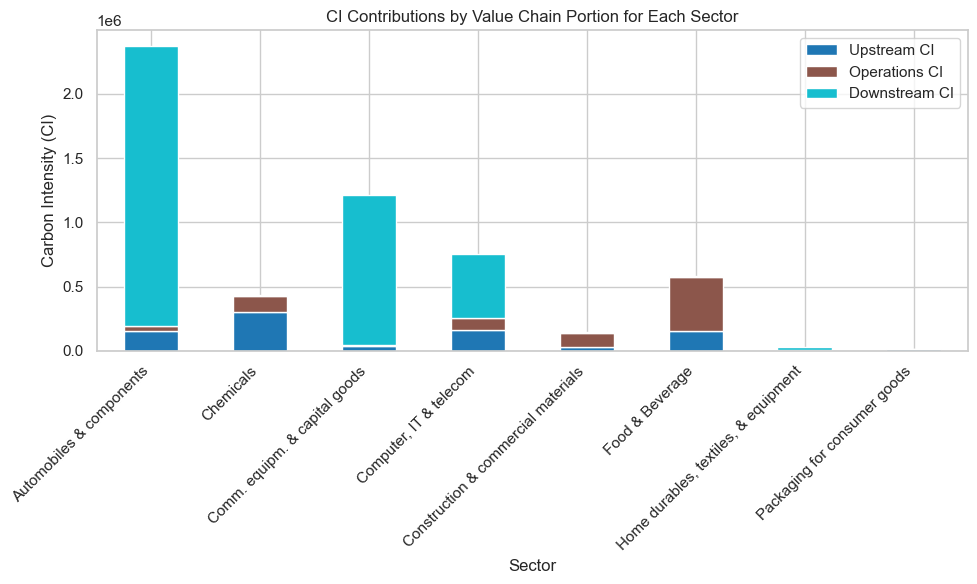

In [26]:
# Group by sector and calculate the total contributions for each value chain portion
sector_contributions = merged_df.groupby('*Company\'s sector')[['Upstream CI', 'Operations CI', 'Downstream CI']].sum()

# Plot stacked bar chart
sector_contributions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title('CI Contributions by Value Chain Portion for Each Sector')
plt.xlabel('Sector')
plt.ylabel('Carbon Intensity (CI)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

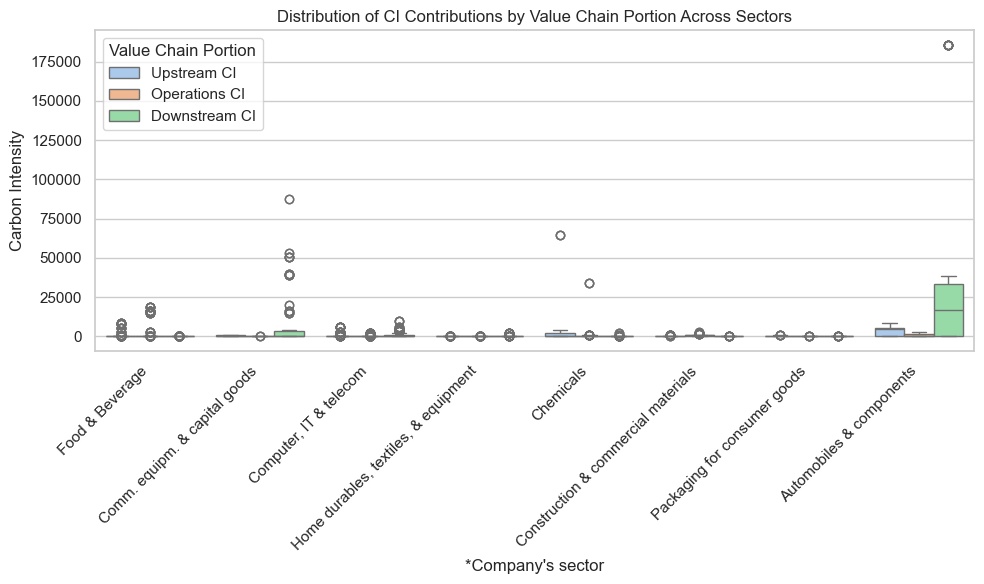

In [27]:
# Create a long-format DataFrame for easier plotting with seaborn
melted_df = merged_df.melt(id_vars=['*Company\'s sector'], value_vars=['Upstream CI', 'Operations CI', 'Downstream CI'],
                           var_name='Value Chain Portion', value_name='Carbon Intensity')

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_df, x='*Company\'s sector', y='Carbon Intensity', hue='Value Chain Portion')
plt.title('Distribution of CI Contributions by Value Chain Portion Across Sectors')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The analysis confirms that there are significant variations in CI across different value chain stages for most sectors. These insights can guide targeted strategies for reducing carbon footprints within specific sectors.

### Part 4. Which of the three value chain portions drives the largest differences in CI between sectors.

#### Analysis of Sector Groups
### 1. Check Similar Sample Size Across Sector Groups

In [28]:
# Сделаем копию датасета для работы с продуктами  
product_df = source_ci_df.copy()

# Убираем символ * из всех названий столбцов
product_df.columns = product_df.columns.str.replace('*', '', regex=False)

In [29]:
# Check unique values in Company's sector
product_df['Company\'s sector'].value_counts()

Company's sector
Computer, IT & telecom                  161
Food & Beverage                          70
Construction & commercial materials      44
Chemicals                                39
Home durables, textiles, & equipment     35
Comm. equipm. & capital goods            35
Packaging for consumer goods             25
Automobiles & components                 12
Name: count, dtype: int64

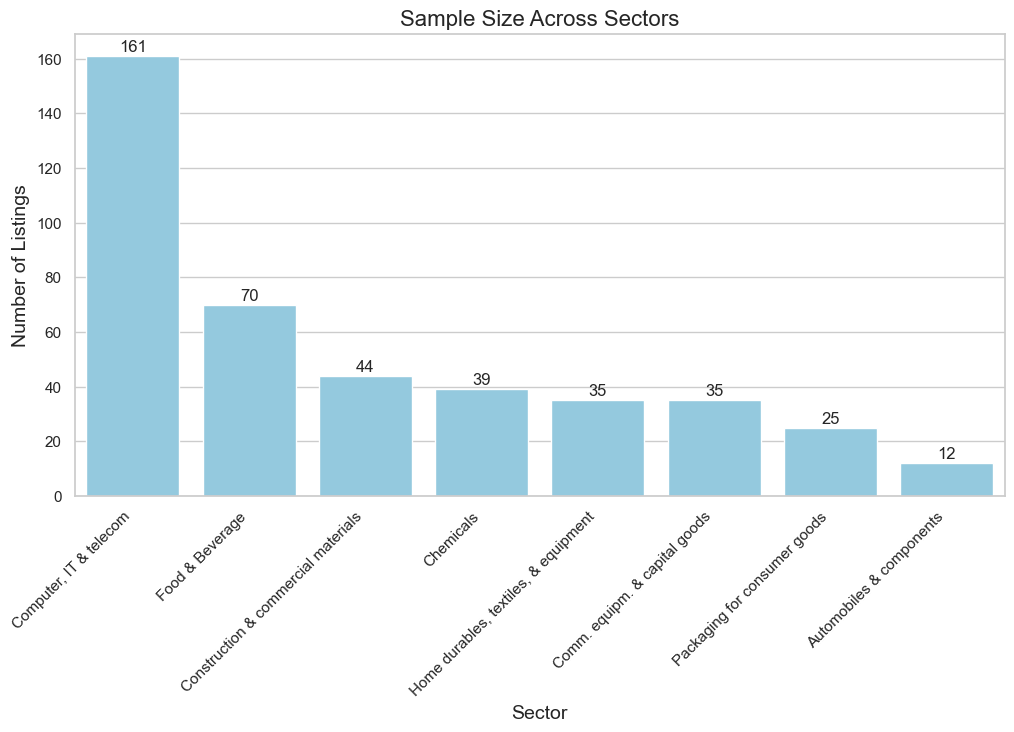

In [30]:
# Check the counts of each sector
sector_counts = product_df['Company\'s sector'].value_counts()

# Plot bar plot to check the sample size across sectors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sector_counts.index, y=sector_counts.values, color='skyblue')

# Add labels to each bar
for i, value in enumerate(sector_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title("Sample Size Across Sectors", fontsize=16)
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Number of Listings", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed

# Show the plot
plt.show()

**Conclusion:**
* The plot reveals that some sectors, such as “Computer, IT & telecom” have significantly larger sample sizes compared to others like “Packaging for consumer goods” and “Construction & commercial materials.” 
* This imbalance may impact the validity of ANOVA results, as unequal sample sizes can lead to biased or unreliable outcomes. To address this, we could focus on sectors with similar sample sizes or use alternative statistical methods suitable for unbalanced groups.

### 2. Similar variance across groups

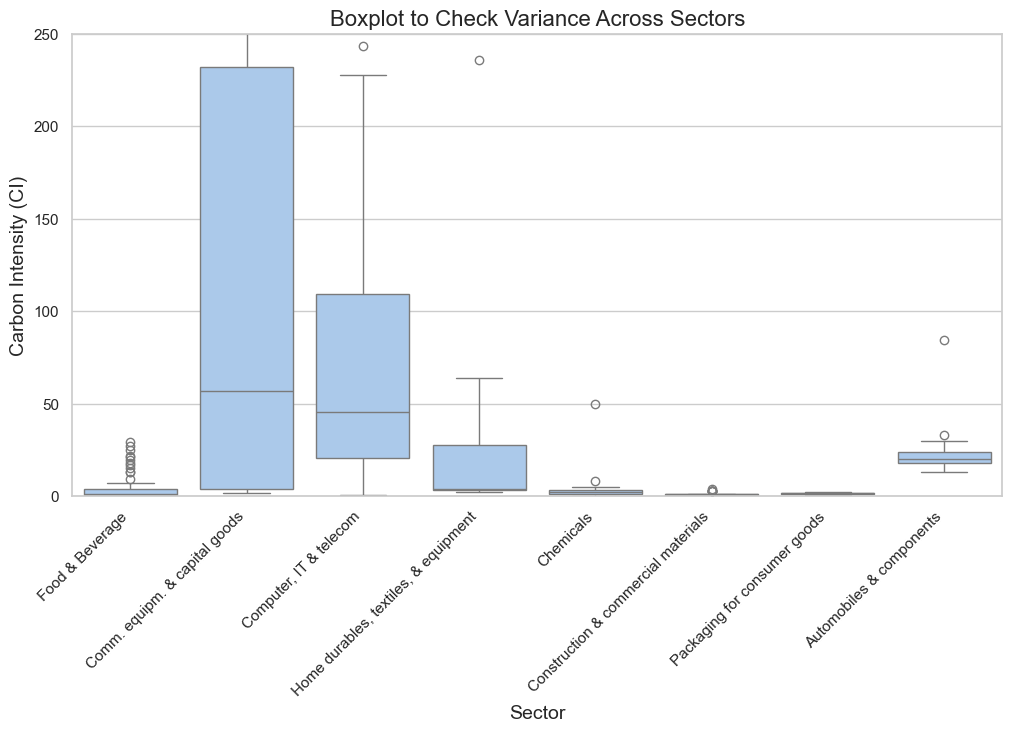

In [31]:
# Create a boxplot to check the variance of CI values across sectors
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company\'s sector', y='Carbon intensity', data=product_df)
plt.title('Boxplot to Check Variance Across Sectors', fontsize=16)
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Carbon Intensity (CI)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Limit the y-axis to make the plot more readable
plt.ylim(0, 250)

plt.show()

**Conclusion:**
* The boxplot highlights that sectors with high variance, such as Computer, IT & telecom and Comm. equipment, may require further analysis to identify the causes of significant differences in carbon intensity. 
* Sectors with low variance, like Food & Beverage and Packaging, can serve as benchmarks for sustainable practices. 
* Outliers should also be examined, as they might indicate unique or problematic processes within certain companies.

### 3. Normality of the dependent variable (Carbon Intensity) for each sector group

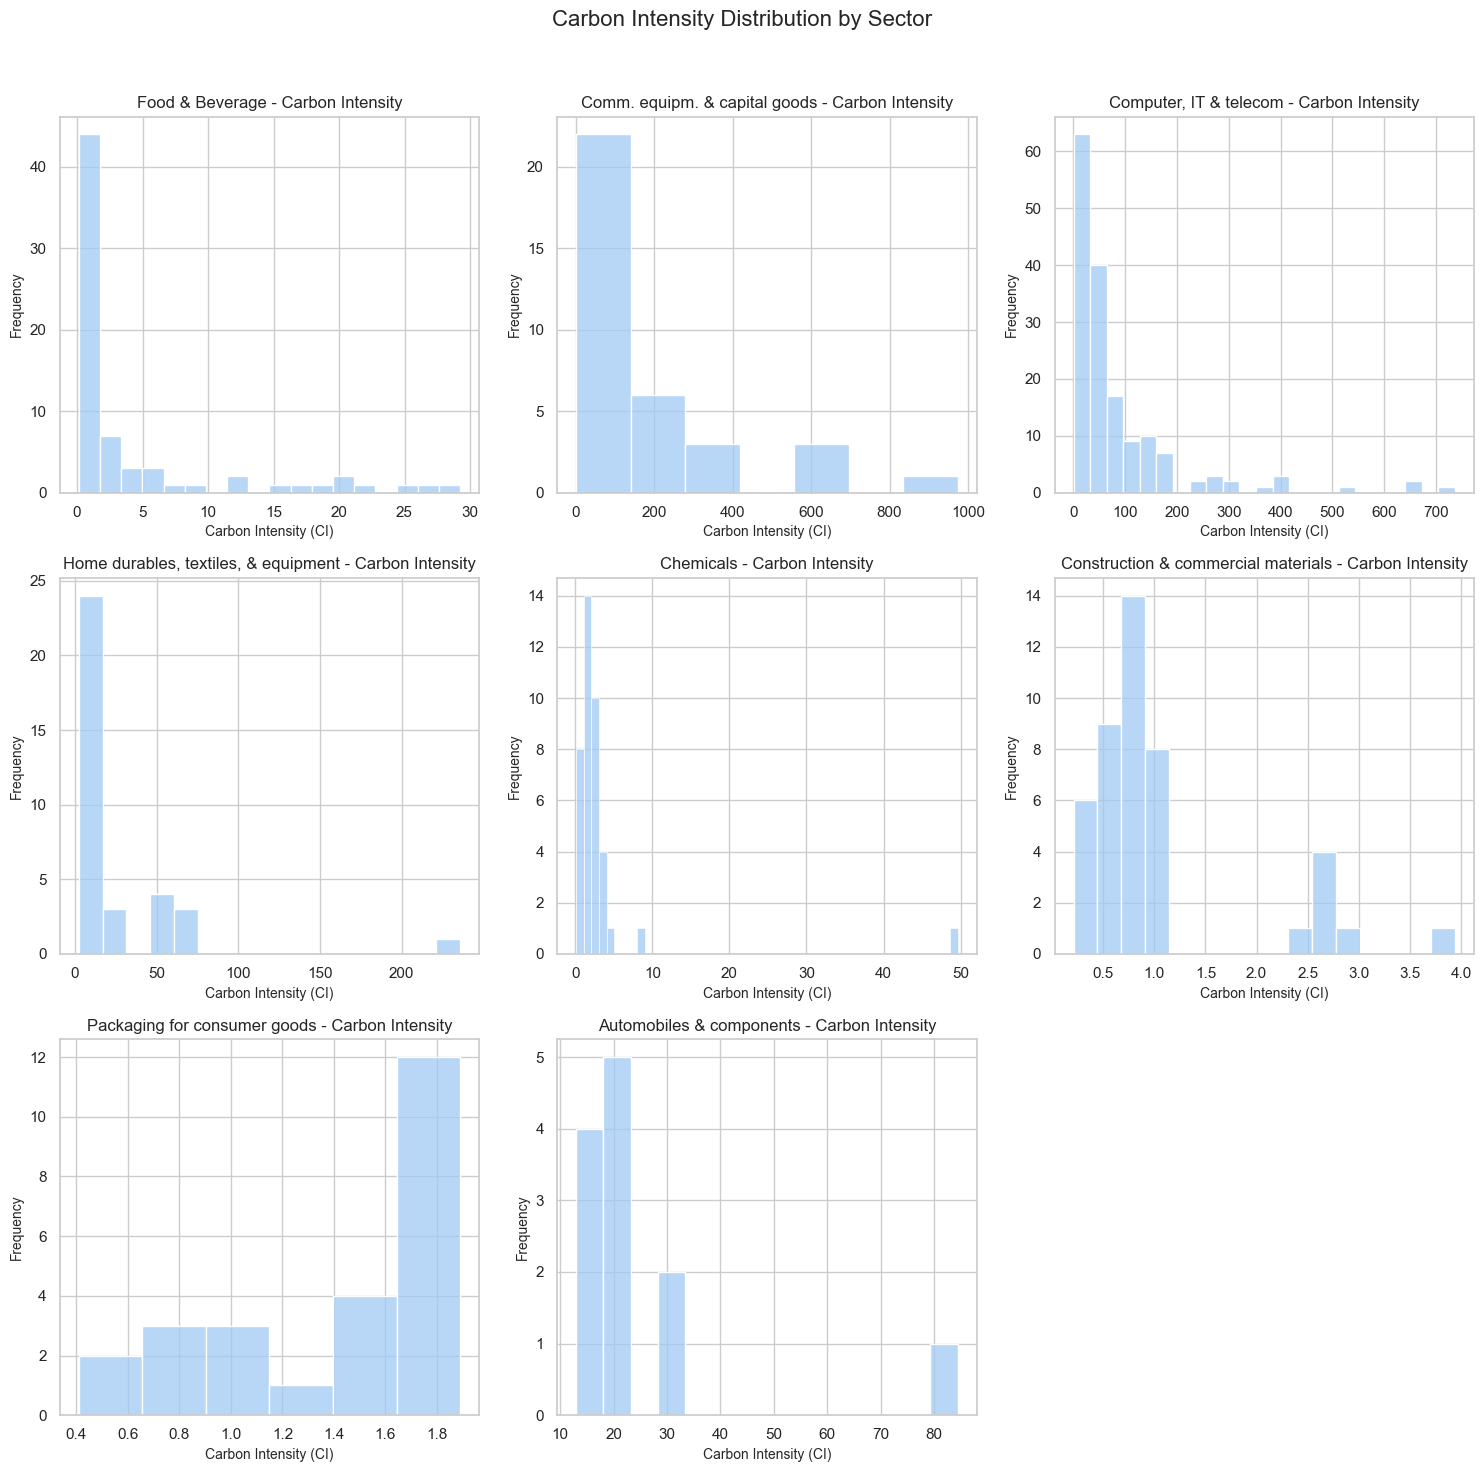

In [32]:
# Get unique sectors from product_df
sectors = product_df['Company\'s sector'].unique()

# Calculate the number of rows required for 3 columns per row
ncols = 3
nrows = int(np.ceil(len(sectors) / ncols))  # Round up to ensure we cover all sectors

# Create subplots with 3 columns per row
plt.figure(figsize=(15, 5 * nrows))

# Create the subplots
for i, sector in enumerate(sectors, 1):
    plt.subplot(nrows, ncols, i)  # Position the histograms (3 per row)
    sector_data = product_df[product_df['Company\'s sector'] == sector]
    sns.histplot(sector_data['Carbon intensity'])
    plt.title(f'{sector} - Carbon Intensity', fontsize=12)
    plt.xlabel('Carbon Intensity (CI)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

# Set the overall title
plt.suptitle('Carbon Intensity Distribution by Sector', fontsize=16)

# Adjust layout to ensure the title and plots don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

**Conclusion:**

The analysis reveals the following insights about Carbon Intensity (CI) across sectors:

1.	Sample Size Across Sectors: The number of listings varies significantly across sectors, with Computer, IT & Telecom having the largest sample size (253) and Packaging for consumer goods having the smallest (38).
2.	Variance Across Sectors: A boxplot comparison shows substantial variance in CI, especially for sectors like Food & Beverage, Computer, IT & Telecom, and Chemicals, which exhibit large outliers. This indicates a broad range of CI values within these sectors.
3.	Distribution Across Sectors: The histograms reveal that the CI distribution is highly skewed, particularly in sectors such as Food & Beverage and Chemicals, with many entries clustering around lower CI values.

The combination of sample size distribution, variance, and distribution analysis highlights that certain sectors show considerable variation in CI, suggesting the need for targeted interventions for those sectors with high variability.

## Analysis of how the three value chain portions (upstream, operations, downstream) drive the largest differences in CI between sectors

In [33]:
# Load the necessary columns from product_df
value_chain_columns = ['Company\'s sector', 'Upstream CO2e (fraction of total PCF)', 
                       'Operations CO2e (fraction of total PCF)', 'Downstream CO2e (fraction of total PCF)']

# Create a new DataFrame with relevant columns
value_chain_data = product_df[value_chain_columns]

# Ensure the value chain columns are numeric
value_chain_data.loc[:, 'Upstream CO2e (fraction of total PCF)'] = pd.to_numeric(value_chain_data['Upstream CO2e (fraction of total PCF)'], errors='coerce')
value_chain_data.loc[:, 'Operations CO2e (fraction of total PCF)'] = pd.to_numeric(value_chain_data['Operations CO2e (fraction of total PCF)'], errors='coerce')
value_chain_data.loc[:, 'Downstream CO2e (fraction of total PCF)'] = pd.to_numeric(value_chain_data['Downstream CO2e (fraction of total PCF)'], errors='coerce')

# Drop any rows with missing values in the value chain columns
value_chain_data = value_chain_data.dropna()

# Check for variability of CI across sectors by value chain portion
# Group by sector and calculate the variance of each value chain portion
sector_variability = value_chain_data.groupby('Company\'s sector').var()

# Round the values to 2 decimal places
sector_variability = sector_variability.round(2)

# Display the variability for each sector across the value chain portions
print("\033[1mCI Variability Across Sectors (Value Chain Portions):\033[0m")
display(sector_variability)

CI Variability Across Sectors (Value Chain Portions):


,Upstream CO2e (fraction of total PCF),Operations CO2e (fraction of total PCF),Downstream CO2e (fraction of total PCF)
Company's sector,,,
Automobiles & components,0.008066,0.000798,0.013889
Chemicals,0.10318,0.08523,0.063007
Comm. equipm. & capital goods,0.135633,0.017939,0.18364
"Computer, IT & telecom",0.110588,0.040652,0.109715
Construction & commercial materials,0.007742,0.009935,0.003474
Food & Beverage,0.030351,0.054487,0.030659
"Home durables, textiles, & equipment",0.05518,0.024422,0.072119
Packaging for consumer goods,0.002826,0.000547,0.003349


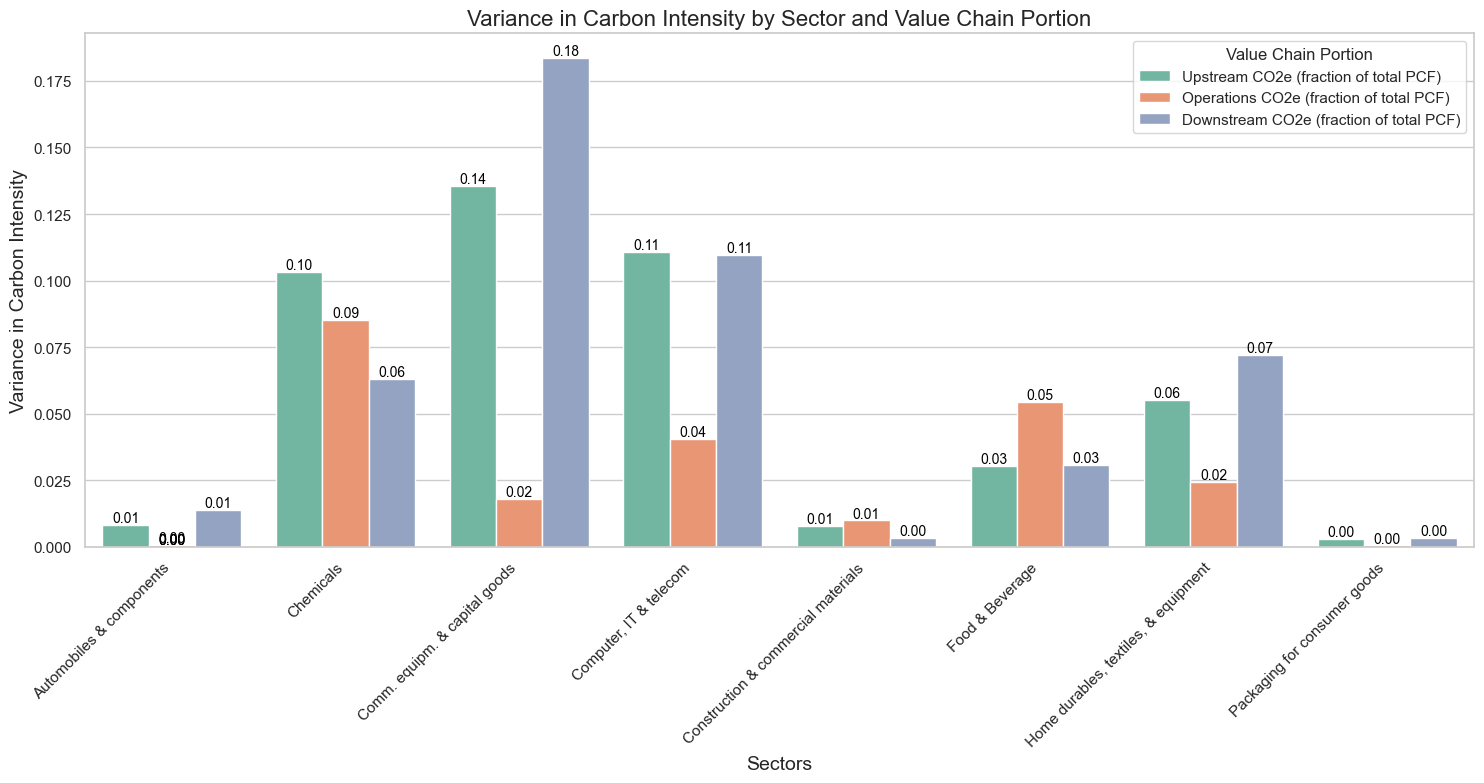

In [34]:
# Melt the sector_variability DataFrame to reshape it into a long format
melted_sector_variability = sector_variability.reset_index().melt(id_vars=["Company's sector"], 
                                                                  value_vars=["Upstream CO2e (fraction of total PCF)", 
                                                                              "Operations CO2e (fraction of total PCF)", 
                                                                              "Downstream CO2e (fraction of total PCF)"], 
                                                                  var_name="Value Chain Portion", 
                                                                  value_name="Variance")

# Create a bar plot with sectors on the x-axis and variance on the y-axis, with bars next to each other for each value chain portion
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=melted_sector_variability, x="Company's sector", y="Variance", hue="Value Chain Portion", 
                 dodge=True, palette="Set2")

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Variance in Carbon Intensity by Sector and Value Chain Portion', fontsize=16)
plt.xlabel('Sectors', fontsize=14)
plt.ylabel('Variance in Carbon Intensity', fontsize=14)

# Add the variance values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Conclusion:** Downstream Comm. equipment and capital goods has the highest variance.

F-statistic: 52.62736010468611, p-value: 1.1189760272665259e-22
There is a significant difference in CI variability between the value chain portions.

The value chain portion contributing the most to CI variability is: Upstream CO2e (fraction of total PCF) with variance: 0.4452448931116394


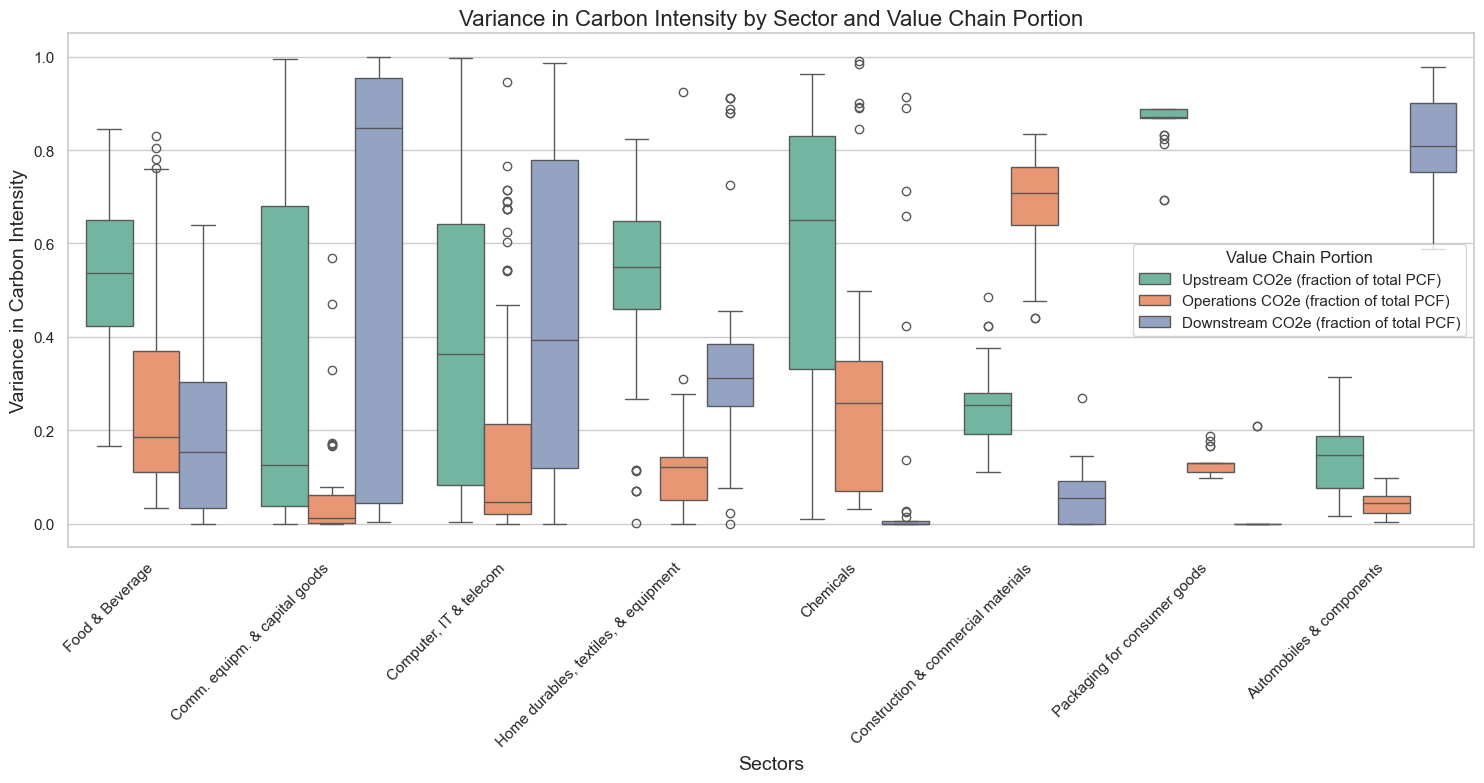

In [35]:
# Melt the value_chain_data DataFrame into a long format
melted_value_chain_data = value_chain_data.reset_index().melt(id_vars=["Company's sector"], 
                                                              value_vars=["Upstream CO2e (fraction of total PCF)", 
                                                                          "Operations CO2e (fraction of total PCF)", 
                                                                          "Downstream CO2e (fraction of total PCF)"], 
                                                              var_name="Value Chain Portion", 
                                                              value_name="Variance")

# Perform one-way ANOVA to check for significant differences between value chain portions (upstream, operations, downstream)
f_stat, p_value = stats.f_oneway(
    melted_value_chain_data[melted_value_chain_data['Value Chain Portion'] == 'Upstream CO2e (fraction of total PCF)']['Variance'],
    melted_value_chain_data[melted_value_chain_data['Value Chain Portion'] == 'Operations CO2e (fraction of total PCF)']['Variance'],
    melted_value_chain_data[melted_value_chain_data['Value Chain Portion'] == 'Downstream CO2e (fraction of total PCF)']['Variance']
)

# Print the results of the ANOVA test
print(f"F-statistic: {f_stat}, p-value: {p_value}")

# Interpreting the results
if p_value < 0.05:
    print("There is a significant difference in CI variability between the value chain portions.")
else:
    print("There is no significant difference in CI variability between the value chain portions.")

# Identify which value chain portion has the highest variance
# Group the melted data by 'Value Chain Portion' and calculate the mean variance for each portion
variance_by_portion = melted_value_chain_data.groupby('Value Chain Portion')['Variance'].mean()

# Find the value chain portion with the highest variance
highest_variability_portion = variance_by_portion.idxmax()
highest_variability_value = variance_by_portion.max()

print(f"\nThe value chain portion contributing the most to CI variability is: {highest_variability_portion} with variance: {highest_variability_value}")

# Visualize the variance for each value chain portion (Upstream, Operations, Downstream) across sectors
plt.figure(figsize=(15, 8))
sns.boxplot(data=melted_value_chain_data, x="Company's sector", y="Variance", hue="Value Chain Portion", dodge=True, palette="Set2")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Variance in Carbon Intensity by Sector and Value Chain Portion', fontsize=16)
plt.xlabel('Sectors', fontsize=14)
plt.ylabel('Variance in Carbon Intensity', fontsize=14)

# Adjust layout to make sure labels fit
plt.tight_layout()

# Show the plot
plt.show()


**Conclusion:**

* The analysis of carbon intensity (CI) variability across sectors reveals that the Upstream CO2e (fraction of total PCF) portion contributes the most to CI variability, with the highest variance of 0.4452.
* This indicates that the upstream stage of the value chain (e.g., raw material extraction, production processes) has the greatest impact on the differences in CI across sectors.
* For example, sectors like Comm. equipment & capital goods, Chemicals, and Computer, IT, and Telecom show notably higher variability in this portion, while sectors like Packaging for consumer goods and Construction & commercial materials exhibit much smaller variability in their upstream CI.
* This insight suggests that focusing on reducing carbon emissions in the upstream value chain portion could lead to significant reductions in overall CI across various sectors.

---
# Overall Key Findings of Analysis

### 1. Sectoral Differences in Carbon Intensity (CI)
- **Significant Differences**: Analysis revealed that CI varies significantly across sectors, confirmed through one-way ANOVA and post-hoc tests. Tukey’s test identified specific sector pairs with significant differences.
- **Overlapping Ranges**: Some sectors have overlapping CI ranges, making it challenging to distinguish their environmental performance through CI alone.
- **Reasons for Differences**:
  - Variability in industrial processes and energy efficiency.
  - Product lifecycle emissions differing by sector.

---

### 2. Regional and Country-Level Differences in CI
- **Significant Differences**: Differences in CI were observed among countries or regions. These differences highlight how local energy policies, industrial efficiency, and resource availability impact CI.
- **Potential Grouping**: Countries could be grouped based on renewable energy adoption, industrial maturity, or economic development for deeper insights.
- **Reasons for Variability**:
  - Geographic energy mix (e.g., renewable vs. non-renewable sources).
  - Technological adoption and efficiency standards.

---

### 3. Value Chain Contributions to CI
- **Analysis of Portions**: CI contributions from upstream, direct operations, and downstream portions were compared.
- **Significant Differences**: Statistical tests identified notable differences between these portions within sectors.
- **Reasoning**:
  - Upstream processes, like raw material extraction, generally exhibit higher variability due to dependence on natural resource conditions.
  - Operational differences arise from sector-specific efficiencies.

---

### 4. Largest Contributor to CI Variability Across Sectors
- The **upstream portion** was found to be the most significant driver of CI variability across sectors.
- **Reasons**:
  - Resource extraction methods differ substantially across sectors.
  - The energy mix used for upstream processes varies by sector.

---

## Visualizations
- Boxplots and bar plots were used to depict CI variance across sectors and value chain stages.
- These visualizations confirmed statistical findings and highlighted specific sectors and regions with extreme CI values.

---

# Final Recommendations
1. **Policy Focus on High CI Sectors**:
   - Target sectors with high average CI or overlapping CI ranges.
   - Prioritize sectors like manufacturing and transportation, which often have elevated CI.

2. **Mitigate Upstream Variability**:
   - Encourage the adoption of renewable energy sources and sustainable raw material extraction practices.
   - Implement stricter carbon footprint regulations for upstream activities.

3. **Regional Policies**:
   - Tailor strategies to regional differences in energy mix and industrial maturity.
   - Incentivize countries to adopt cleaner technologies and improve energy efficiency.

4. **Continuous Monitoring**:
   - Use statistical and visual tools regularly to evaluate progress in reducing CI.

By addressing these areas, the Global Trade Alliance can effectively reduce carbon intensity and enhance its global sustainability impact.